# Testing different ML models to predict gene set scores from surface protein data

In this notebook different reggressors (RandomForestRegressor, GradientBoostingReggressor, CatBoostRegressor) are tested to predict gene set scores from CLR tranformed surface protein data.

All three reggressors, Random Forest, Gradient boosting and Catboost, are ensembles of decision trees. Random forest is a very popular algorithm, having high accuracy and working efficiently with high dimensional data. While Random forest aggregates results of multiple independently built decision trees, gradient boosting methods built decision trees so, that each new tree aims to correct the errors of the previously fitted ones and this way gradually improves the model. Consequently, gradient boosting methods could be more accurate than Random forest, but are more prone to overfitting. Regressors produce feature importances, which are here used to find important surface protein markers for studied gene set scores, that are representative for specific NK cell subtype. Used gene sets were collected from Melsen et al., (2022) paper. Not all genes identified in Yang study were found in Neurips data, so gene sets are not completely comparable. Additionally, analyzed gene sets were relatively small and not all genes were highly expressed in Neurips data, which might affect to analysis done in this notebook.

Neurips data was analysed at 4 different sites. Protein data used in this notebooks is limited to only sites 1 and 4, since it was earlier observed that these sites are showing better antibody signals compared to sites 2 and 3. Only NK cells from samples analyzed at sites 1 and 4 are selected for analysis.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import anndata as ad
import scvi
import scanpy as sc
import seaborn as sb


from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score



Global seed set to 0
/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
#loading data
eg_nk = sc.read_h5ad('/Users/tiinatuononen/Documents/GitHub/Thesis/Neurips/gene_set_scores/adata_for_regressor.h5ad')

In [4]:
eg_nk

AnnData object with n_obs × n_vars = 2640 × 21720
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_r2', 'leiden_r2_n_genes_MAD_diff', 'leiden_r2_n_counts_MAD_diff', 'leiden_r2_percent_mito_MAD_diff', 'filter', 'model_group', 'BATCH', 'POOL', 'SAMPLE_SET', 'SAMPLE_TYPE', 'SAMPLE_TISSUE', 'DIAGNOSIS', 'SUBTYPE', 'STATUS', 'CD86', 'CD274', 'CD270', 'CD155', 'CD112', 'CD47_prot', 'CD48', 'CD40', 'CD154', 'CD52_prot', 'CD3', 'CD8', 'CD56', 'CD19', 'CD33', 'CD11c', 'HLA-A-B-C', 'CD45RA', 'CD123', 'CD7_prot', 'CD105', 'CD49f', 'CD194', 'CD4', 'CD44_prot', 'CD14', 'CD16

In [6]:
eg_nk.obs['Site'].unique().tolist()

['site4', 'site1']

In [7]:
eg_nk.obs['cell_type'].unique().tolist()

['NK', 'NK CD158e1+']

## Calculating gene scores for gene sets

In [8]:
prot = eg_nk.obsm['protein_expression_clr_neurips']

In [9]:
#dropping columns containing only zeros

prot = prot.loc[:, (prot!=0).any(axis=0)]

In [10]:
#Summary statistics 

prot.describe()

,CD86,CD274,CD270,CD155,CD112,CD47,CD48,CD40,CD154,CD52,...,CD94,CD162,CD85j,CD23,CD328,HLA-E,CD82,CD101,CD88,CD224
count,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,...,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000
mean,0.259739,1.044477,1.077427,0.575894,0.826136,1.593414,1.468572,0.757240,0.989188,0.785021,...,2.695500,1.842853,0.708465,0.999731,2.870358,1.253904,0.504434,0.574611,0.820453,0.738894
std,0.328835,0.675683,0.335722,0.379068,0.415217,0.436319,0.447961,0.374219,0.417811,0.421535,...,1.222390,0.656122,0.419833,0.419200,0.942209,0.366789,0.279724,0.305433,0.321915,0.430546
min,0.000000,0.000000,0.166149,0.000000,0.000000,0.349275,0.201874,0.000000,0.000000,0.000000,...,0.257817,0.000000,0.000000,0.081182,0.000000,0.204475,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.453643,0.856802,0.306698,0.505917,1.303571,1.151323,0.512721,0.663922,0.512170,...,1.660982,1.407198,0.391222,0.657651,2.332854,0.993845,0.353792,0.329073,0.605141,0.430053
50%,0.000000,1.001407,1.063974,0.541080,0.766577,1.560743,1.418692,0.749707,0.925184,0.735717,...,2.591687,1.879785,0.671706,0.958123,2.948787,1.251529,0.492675,0.519947,0.809714,0.729806
75%,0.378666,1.491603,1.311364,0.890243,1.144269,1.852154,1.726866,1.024682,1.323007,1.013739,...,3.670459,2.322979,0.984231,1.332566,3.517752,1.482333,0.614600,0.728330,1.054625,1.000442
max,4.037784,7.179674,6.503963,3.066146,2.308017,3.565268,4.167115,2.040997,2.384986,2.846132,...,5.781869,4.388661,2.238449,3.030348,5.379574,2.666251,3.958134,2.975896,3.458393,2.980588


- Protein counts are already CLR normalized and appear to have the same scale, so no standardization step is needed.

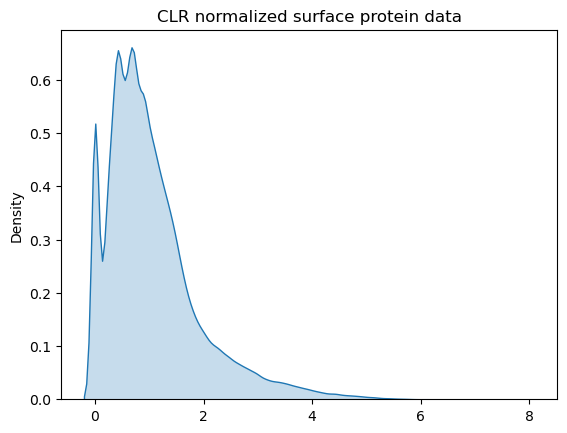

In [11]:
flatten_df = prot.to_numpy().flatten()

sb.kdeplot(flatten_df, fill = True) ; 


plt.title("CLR normalized surface protein data") ;

In [13]:
score = eg_nk.obs['mature_score_yang']

In [14]:
score

GTAGTACCAATCCTTT-1-s4d1    1.081415
CTGTGGGTCATGCGGC-1-s4d1    1.732371
GCAACATTCGCAAGAG-1-s4d1    0.142511
TCACGGGTCGCACGAC-1-s4d1    1.720808
CGCCAGAAGACCATTC-1-s4d1    1.894504
                             ...   
ATCATTCGTCCAATCA-1-s1d3    1.424578
ACATTTCCAGCAGTGA-1-s1d3    1.666697
TGAGACTTCCTTCAGC-1-s1d3    1.064045
GAGATGGTCCGCCTAT-1-s1d3    1.972877
ACCTGTCTCACAGTGT-1-s1d3    1.180738
Name: mature_score_yang, Length: 2640, dtype: float64

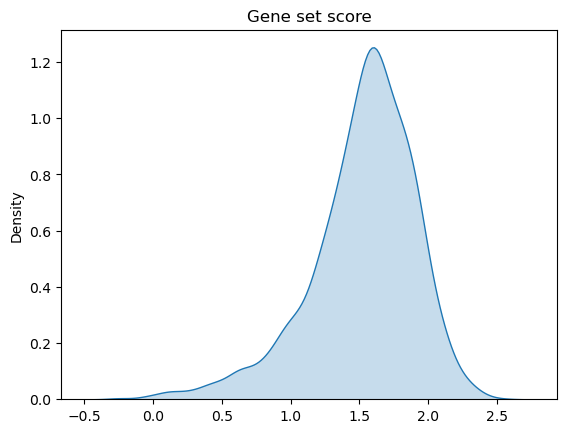

In [15]:
flatten_df1 = score.to_numpy().flatten()

sb.kdeplot(flatten_df1, fill = True) ; 

plt.title("Gene set score") ;

In [16]:
#Creating df containign surface protein data + scores for gene sets

a = score
b = prot

df =pd.concat([a, b], axis=1)


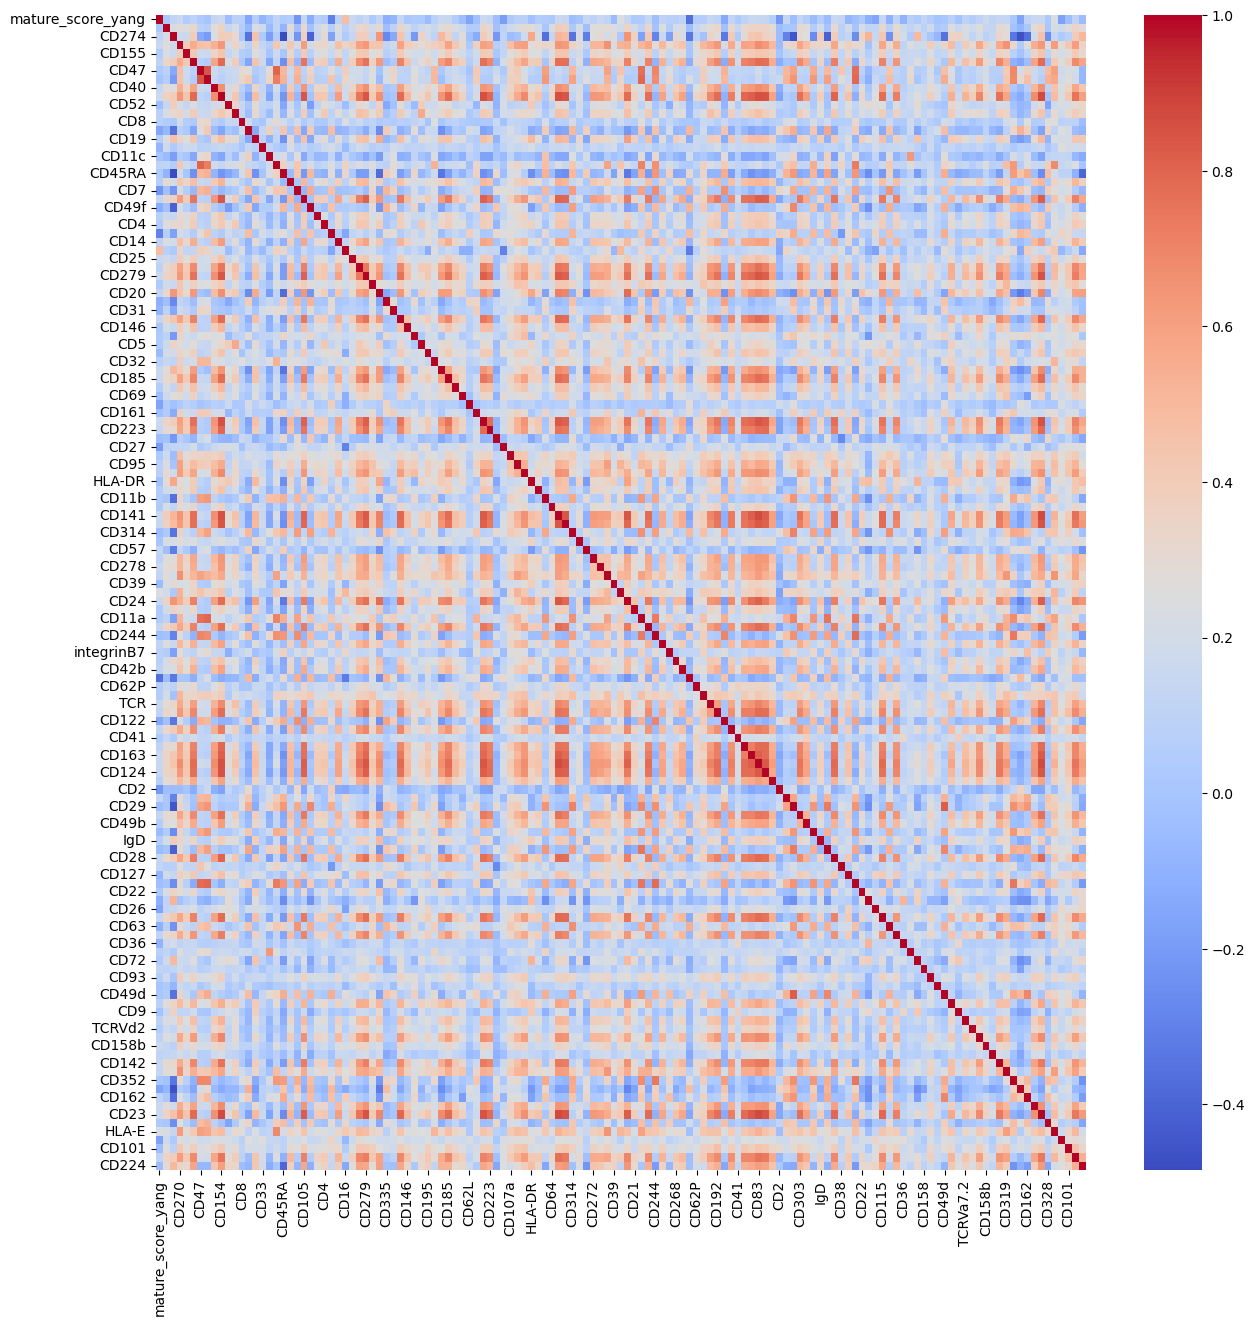

In [17]:
plt.figure(figsize=(15,15))
sb.heatmap(data=df.corr(),cmap='coolwarm')
plt.show()

- According to correlation matrix above, variables are mostly independent and there is no severe multicollinearity problem in the data.

## 1. RandomForestRegressor

In [73]:
#Random forest

X = df.iloc[:, 1:]
y = df['mature_score_yang']

mean_train_score = []

params = {#'bootstrap': [True, False],
 'max_depth': [3,5,7],
 #'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
 'min_samples_leaf': [2, 5, 10],
 #'min_samples_split': [2, 5, 10] ,
 #'n_estimators': [10, 50, 100]
}


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)


#Step 2: hyperparameter search
search= GridSearchCV(RandomForestRegressor(), params, cv= 10, scoring='neg_mean_squared_error', return_train_score = True)
result = search.fit(X_train,y_train)
#collecting training scores and saving into mean_train_score
train_scores_mean = (search.cv_results_['mean_train_score']) 
mean_train_score.append(train_scores_mean)
#Step 3: Performance on test set
best_model = result.best_estimator_
y_pred = best_model.predict(X_test)

MSE = mean_squared_error(y_test, y_pred)
R2= r2_score(y_test, y_pred)
    
print("Mean squared error: %.2f" % MSE, 'R2 score: %.2f'% R2)
    

Mean squared error: 0.10 R2 score: 0.34


In [21]:
#Mean training scores

print(mean_train_score)

[array([-0.09743219, -0.09757839, -0.0978446 , -0.0760923 , -0.07720968,
       -0.07991961, -0.05747132, -0.05999705, -0.06691962])]


In [22]:
# The best score and parameters

print(result.best_score_)
print(result.best_params_)

-0.09839657871200588
{'max_depth': 7, 'min_samples_leaf': 5}


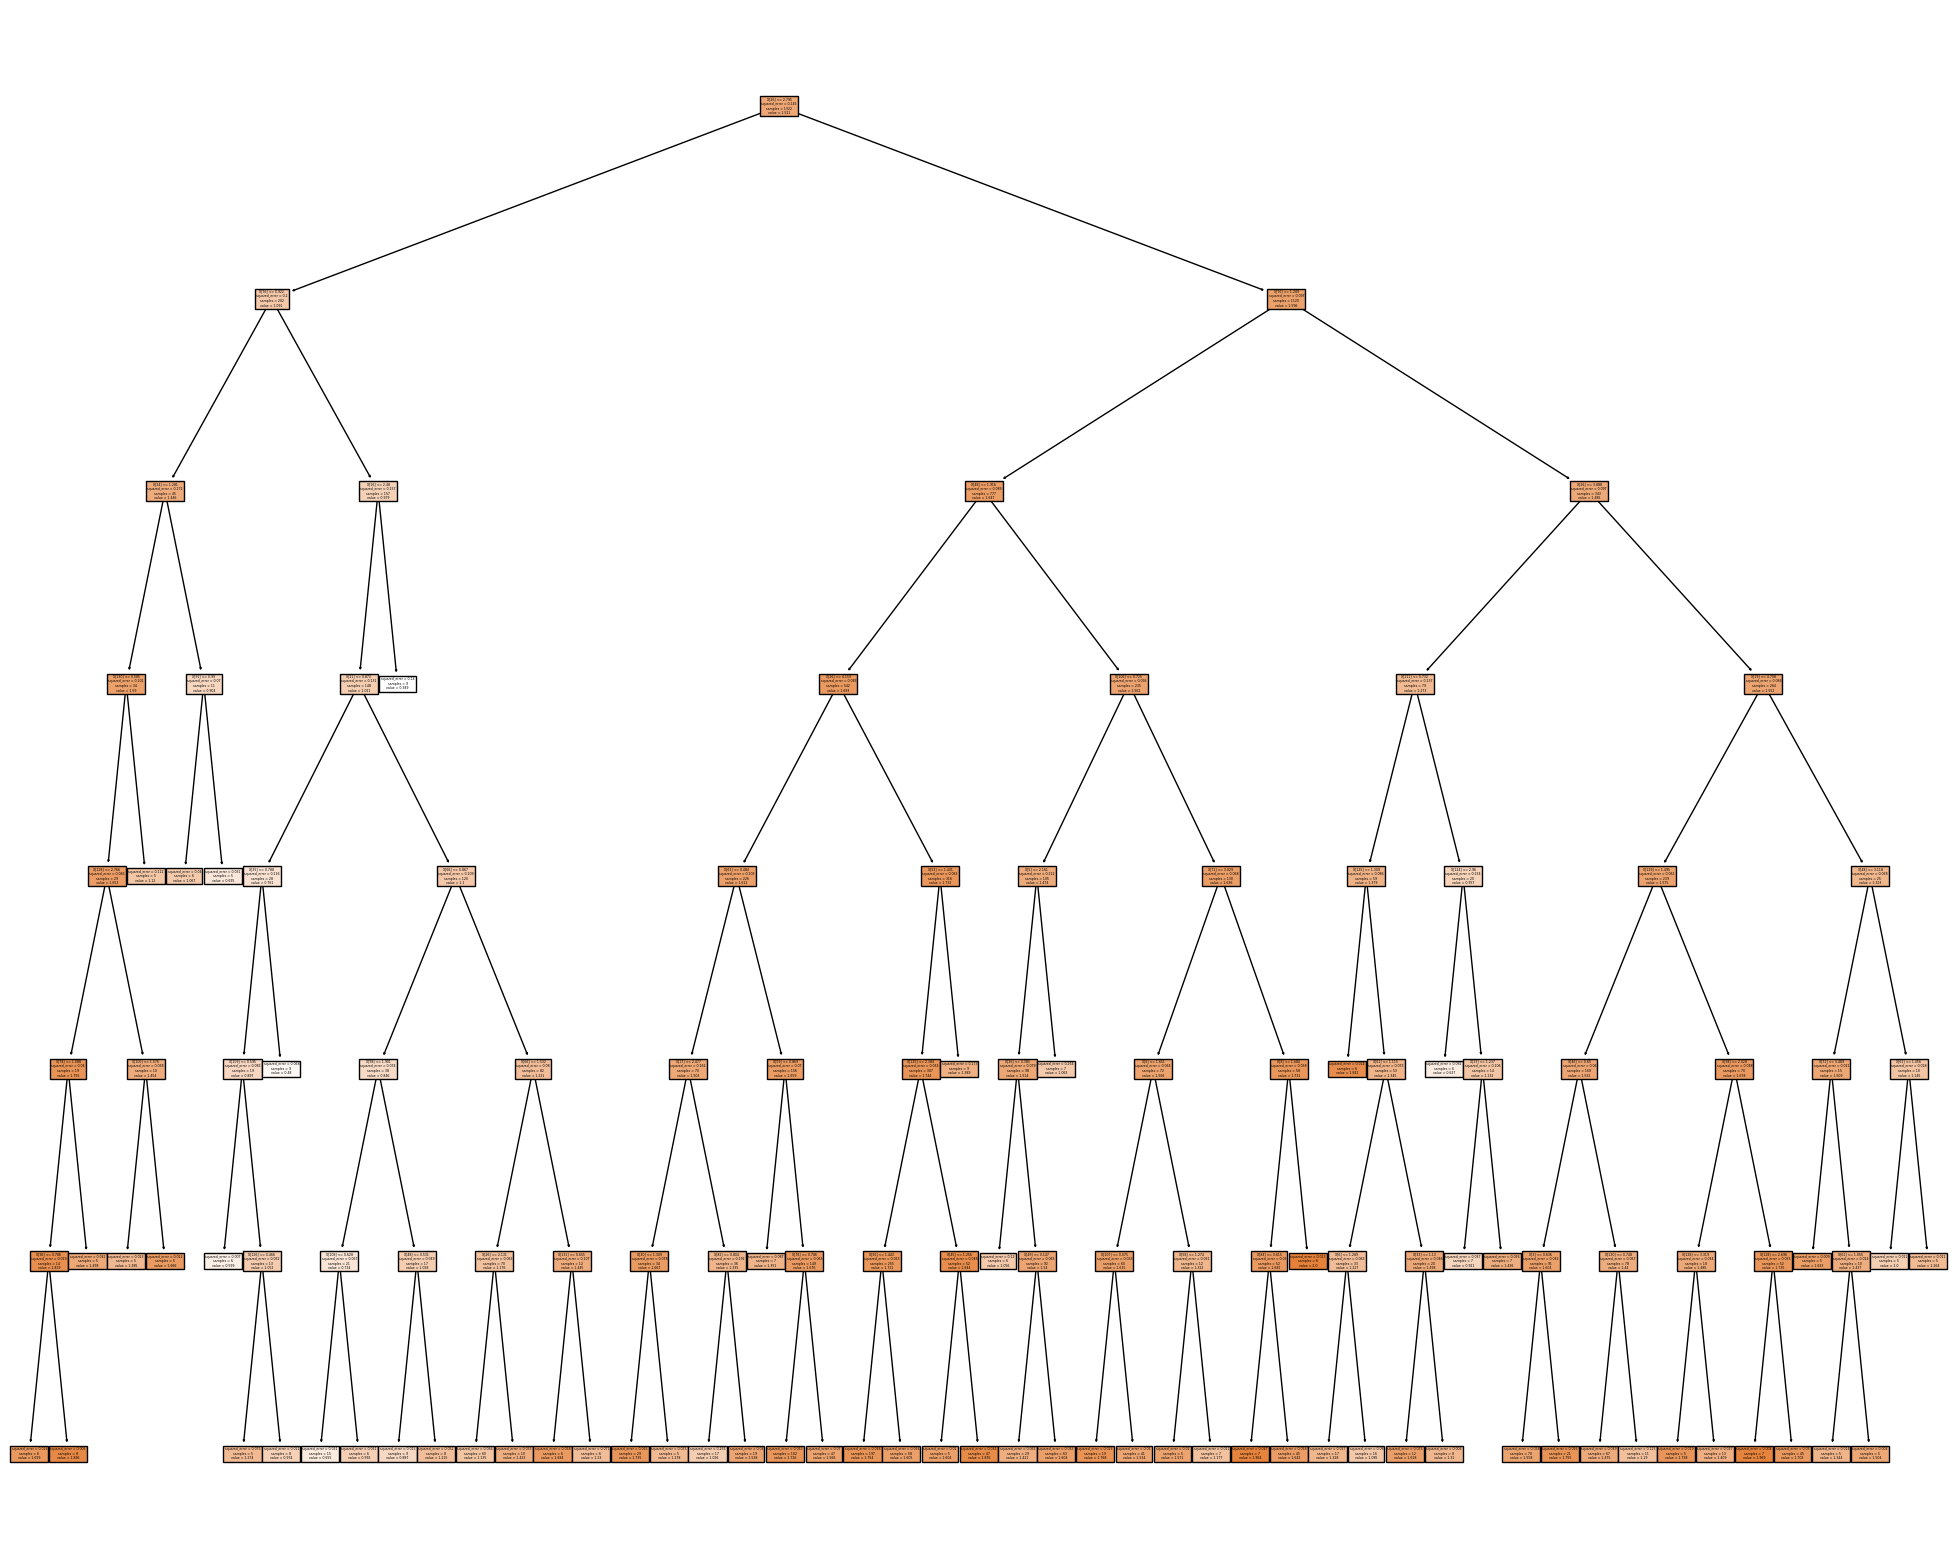

In [23]:
from sklearn import tree

plt.figure(figsize=(25, 20)) # Resize figure
tree.plot_tree(best_model.estimators_[0], filled = True) ;

plt.show()

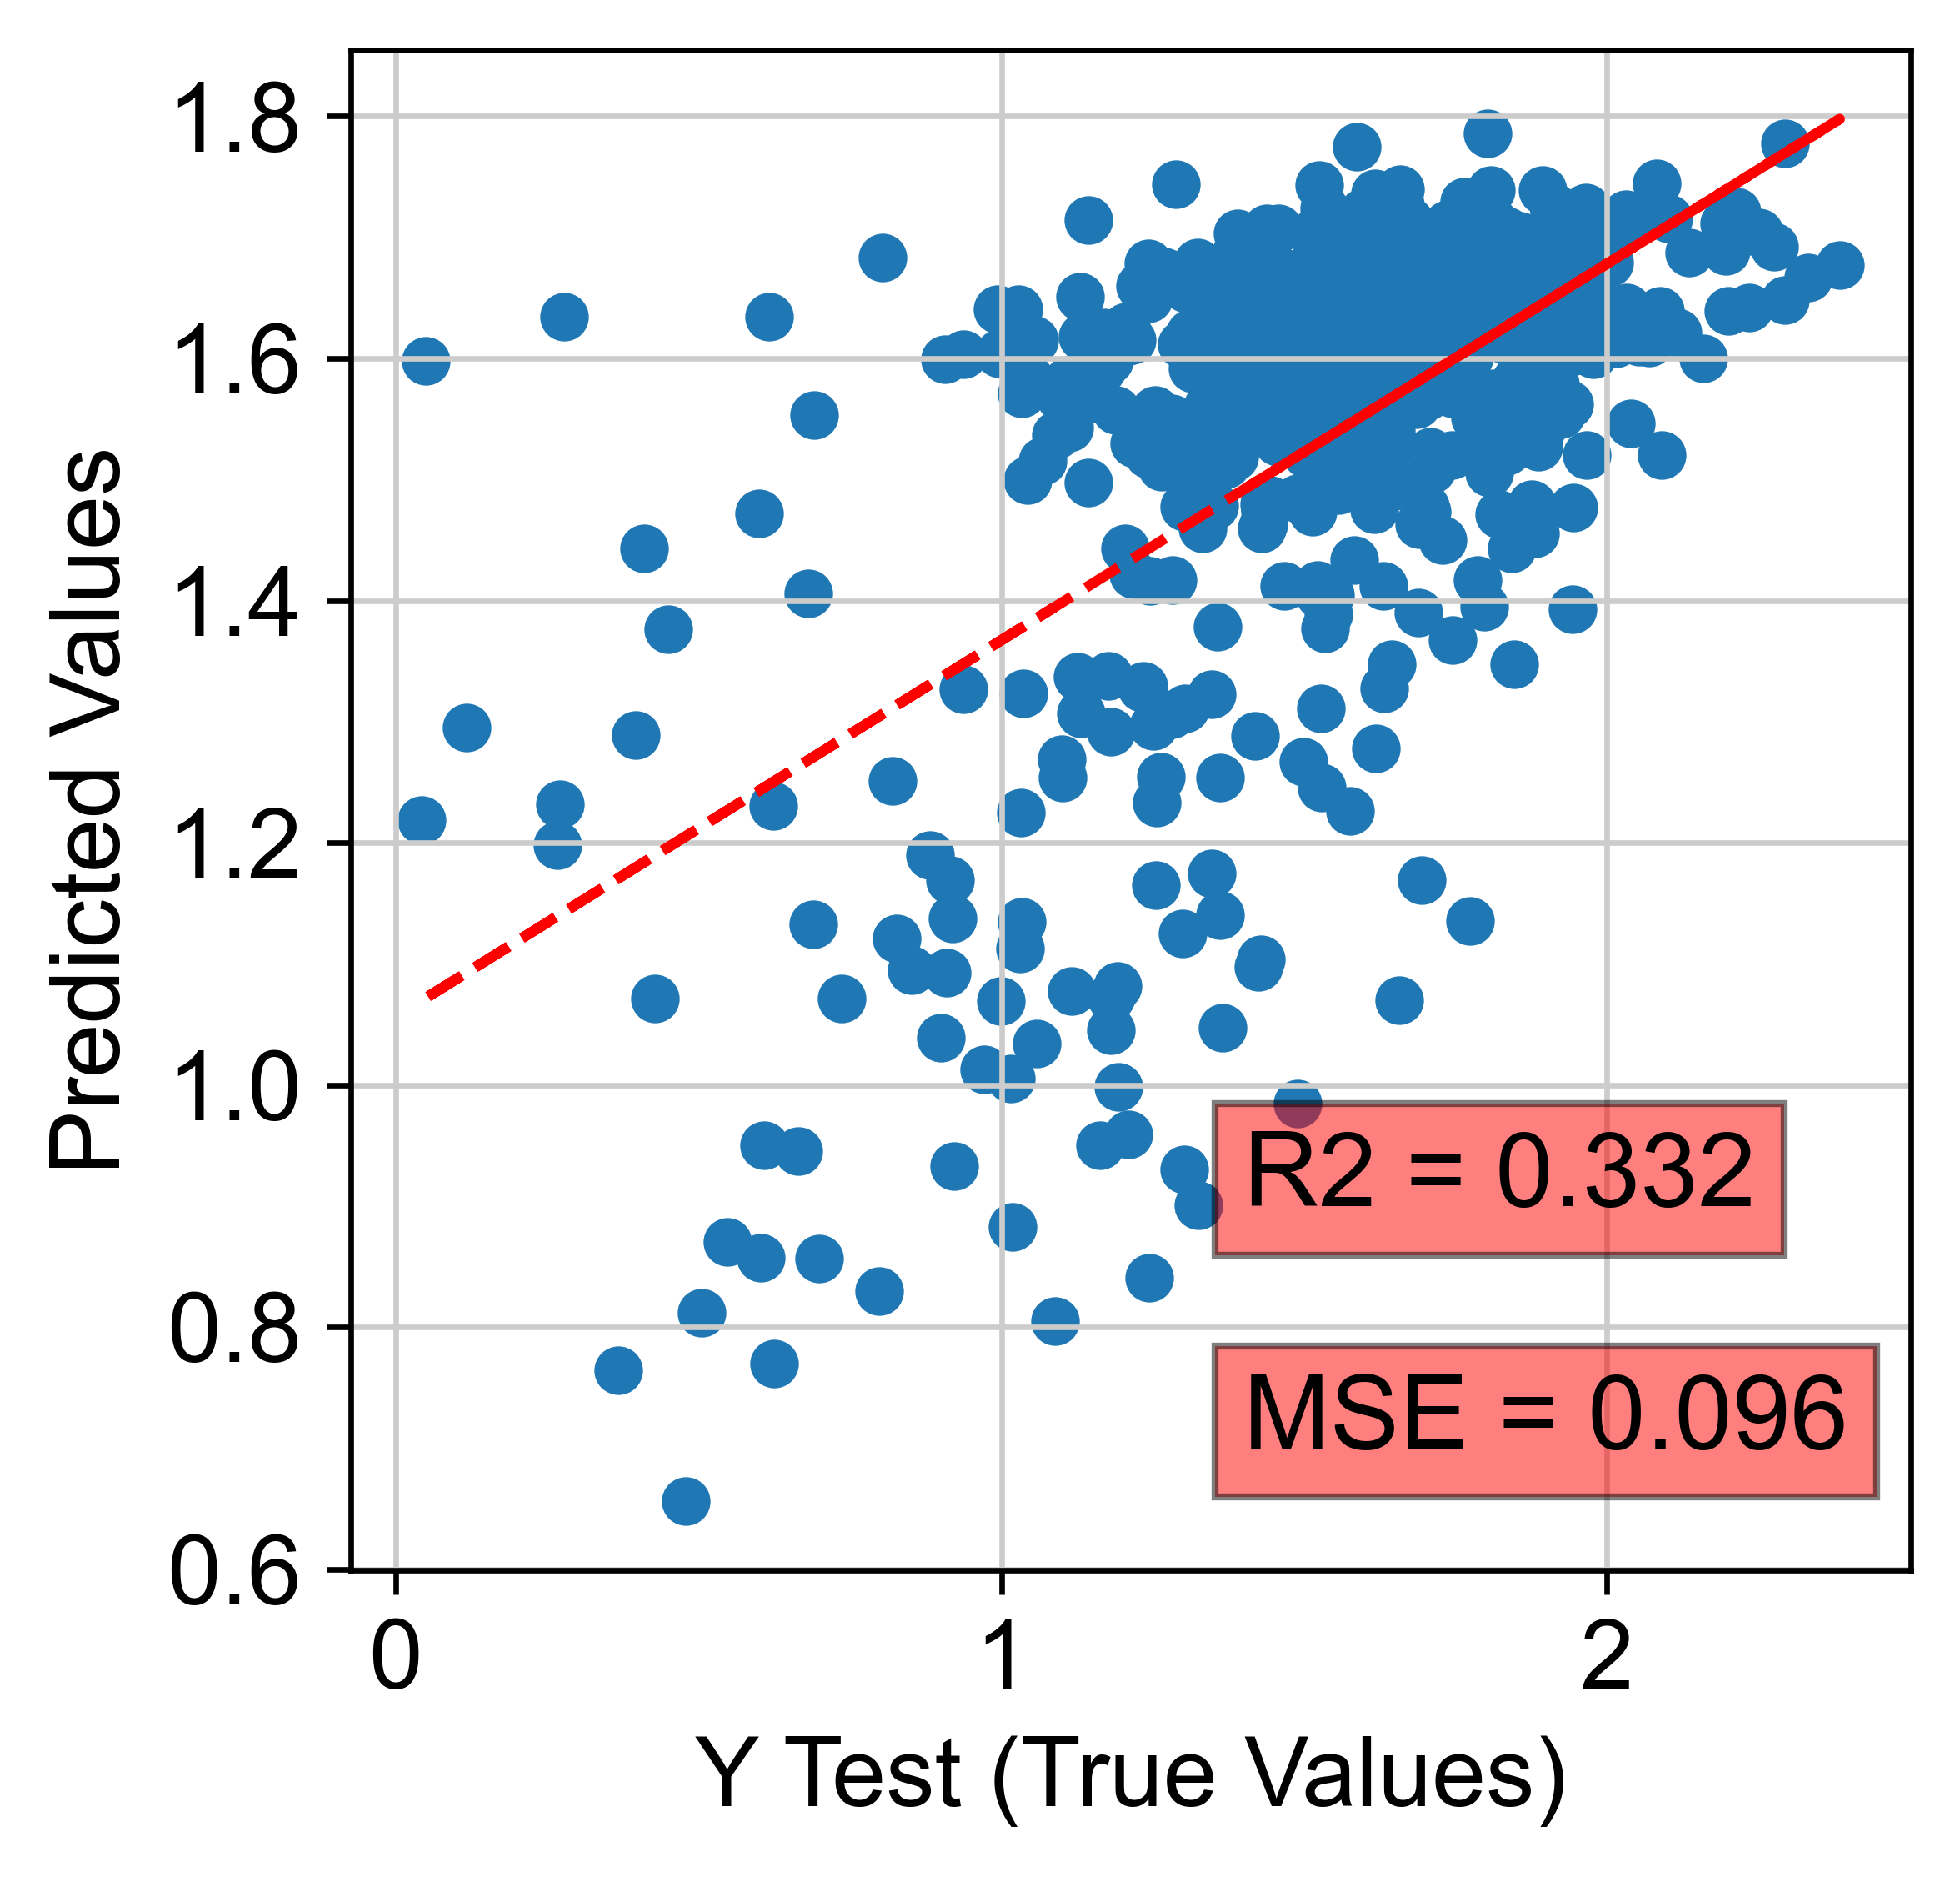

In [42]:
sc.settings.set_figure_params(dpi=300, dpi_save=400, vector_friendly=True)


dict_error = { "Mean Squared Error": MSE,
             'R2': R2}


{ "Mean Squared Error": MSE,
             'R2': R2}
plt.scatter(y_test, y_pred)

# Add a trendline
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), 'r--')
# Add labels
plt.xlabel('Y Test (True Values)')
plt.ylabel('Predicted Values')

plt.annotate("MSE = {:.3f}".format(MSE), (1.4, 0.7), bbox = dict(facecolor = 'red', alpha = 0.5), fontsize=15)

plt.annotate("R2 = {:.3f}".format(R2), (1.4, 0.9), bbox = dict(facecolor = 'red', alpha = 0.5), fontsize=15)


plt.show()

<AxesSubplot: xlabel='mature_score_yang', ylabel='Density'>

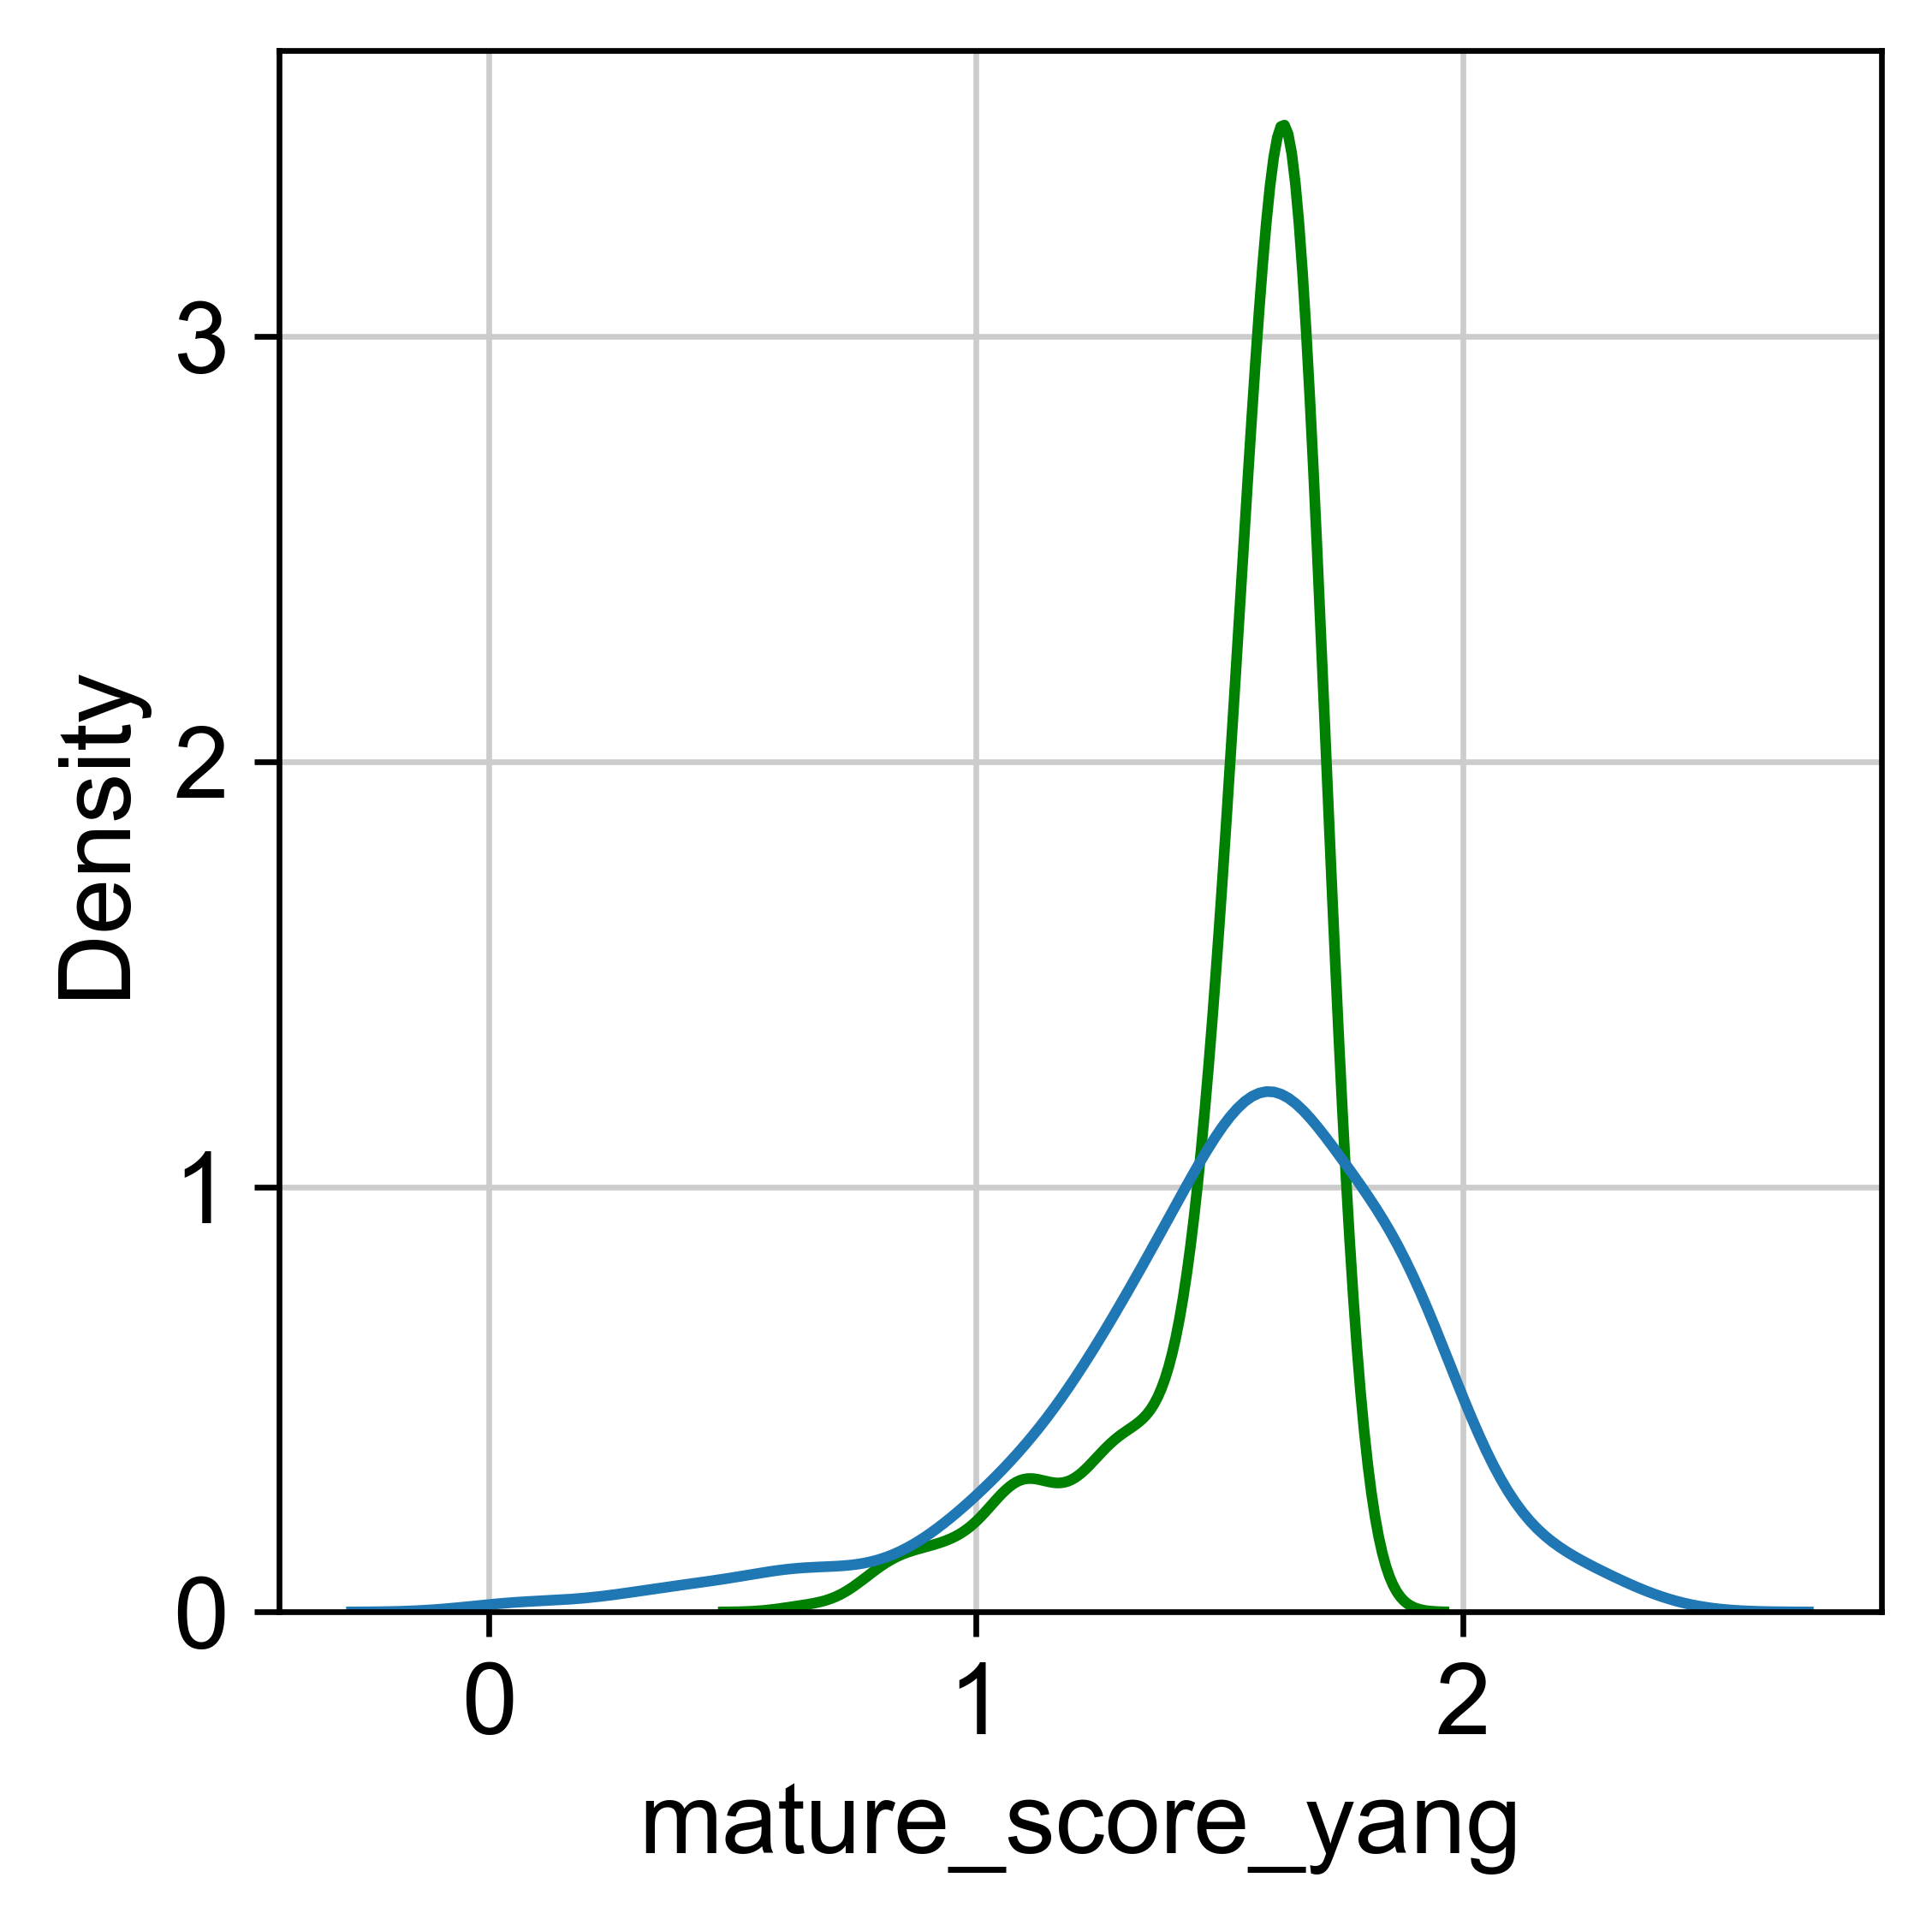

In [43]:
sb.kdeplot(y_pred, color = "g") #predicted values
sb.kdeplot(y_test) #observed values

In [44]:
#Feature importances

importances_rf = best_model.feature_importances_
importances_rf = pd.Series(importances_rf, index=prot.columns)
importances_rf=importances_rf.sort_values(ascending=False)

print(importances_rf.head(10))

CD16     0.399967
CD54     0.065411
CD44     0.042286
CD47     0.029161
CD7      0.018247
KLRG1    0.017024
CD57     0.015423
CD2      0.013837
CD71     0.012981
HLA-E    0.012251
dtype: float64


In [45]:
#df from the top 20 important markers
importances_rf=pd.DataFrame(importances_rf)
importances_rf_top=importances_rf[0:10]
importances_rf_top=importances_rf_top.T

/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


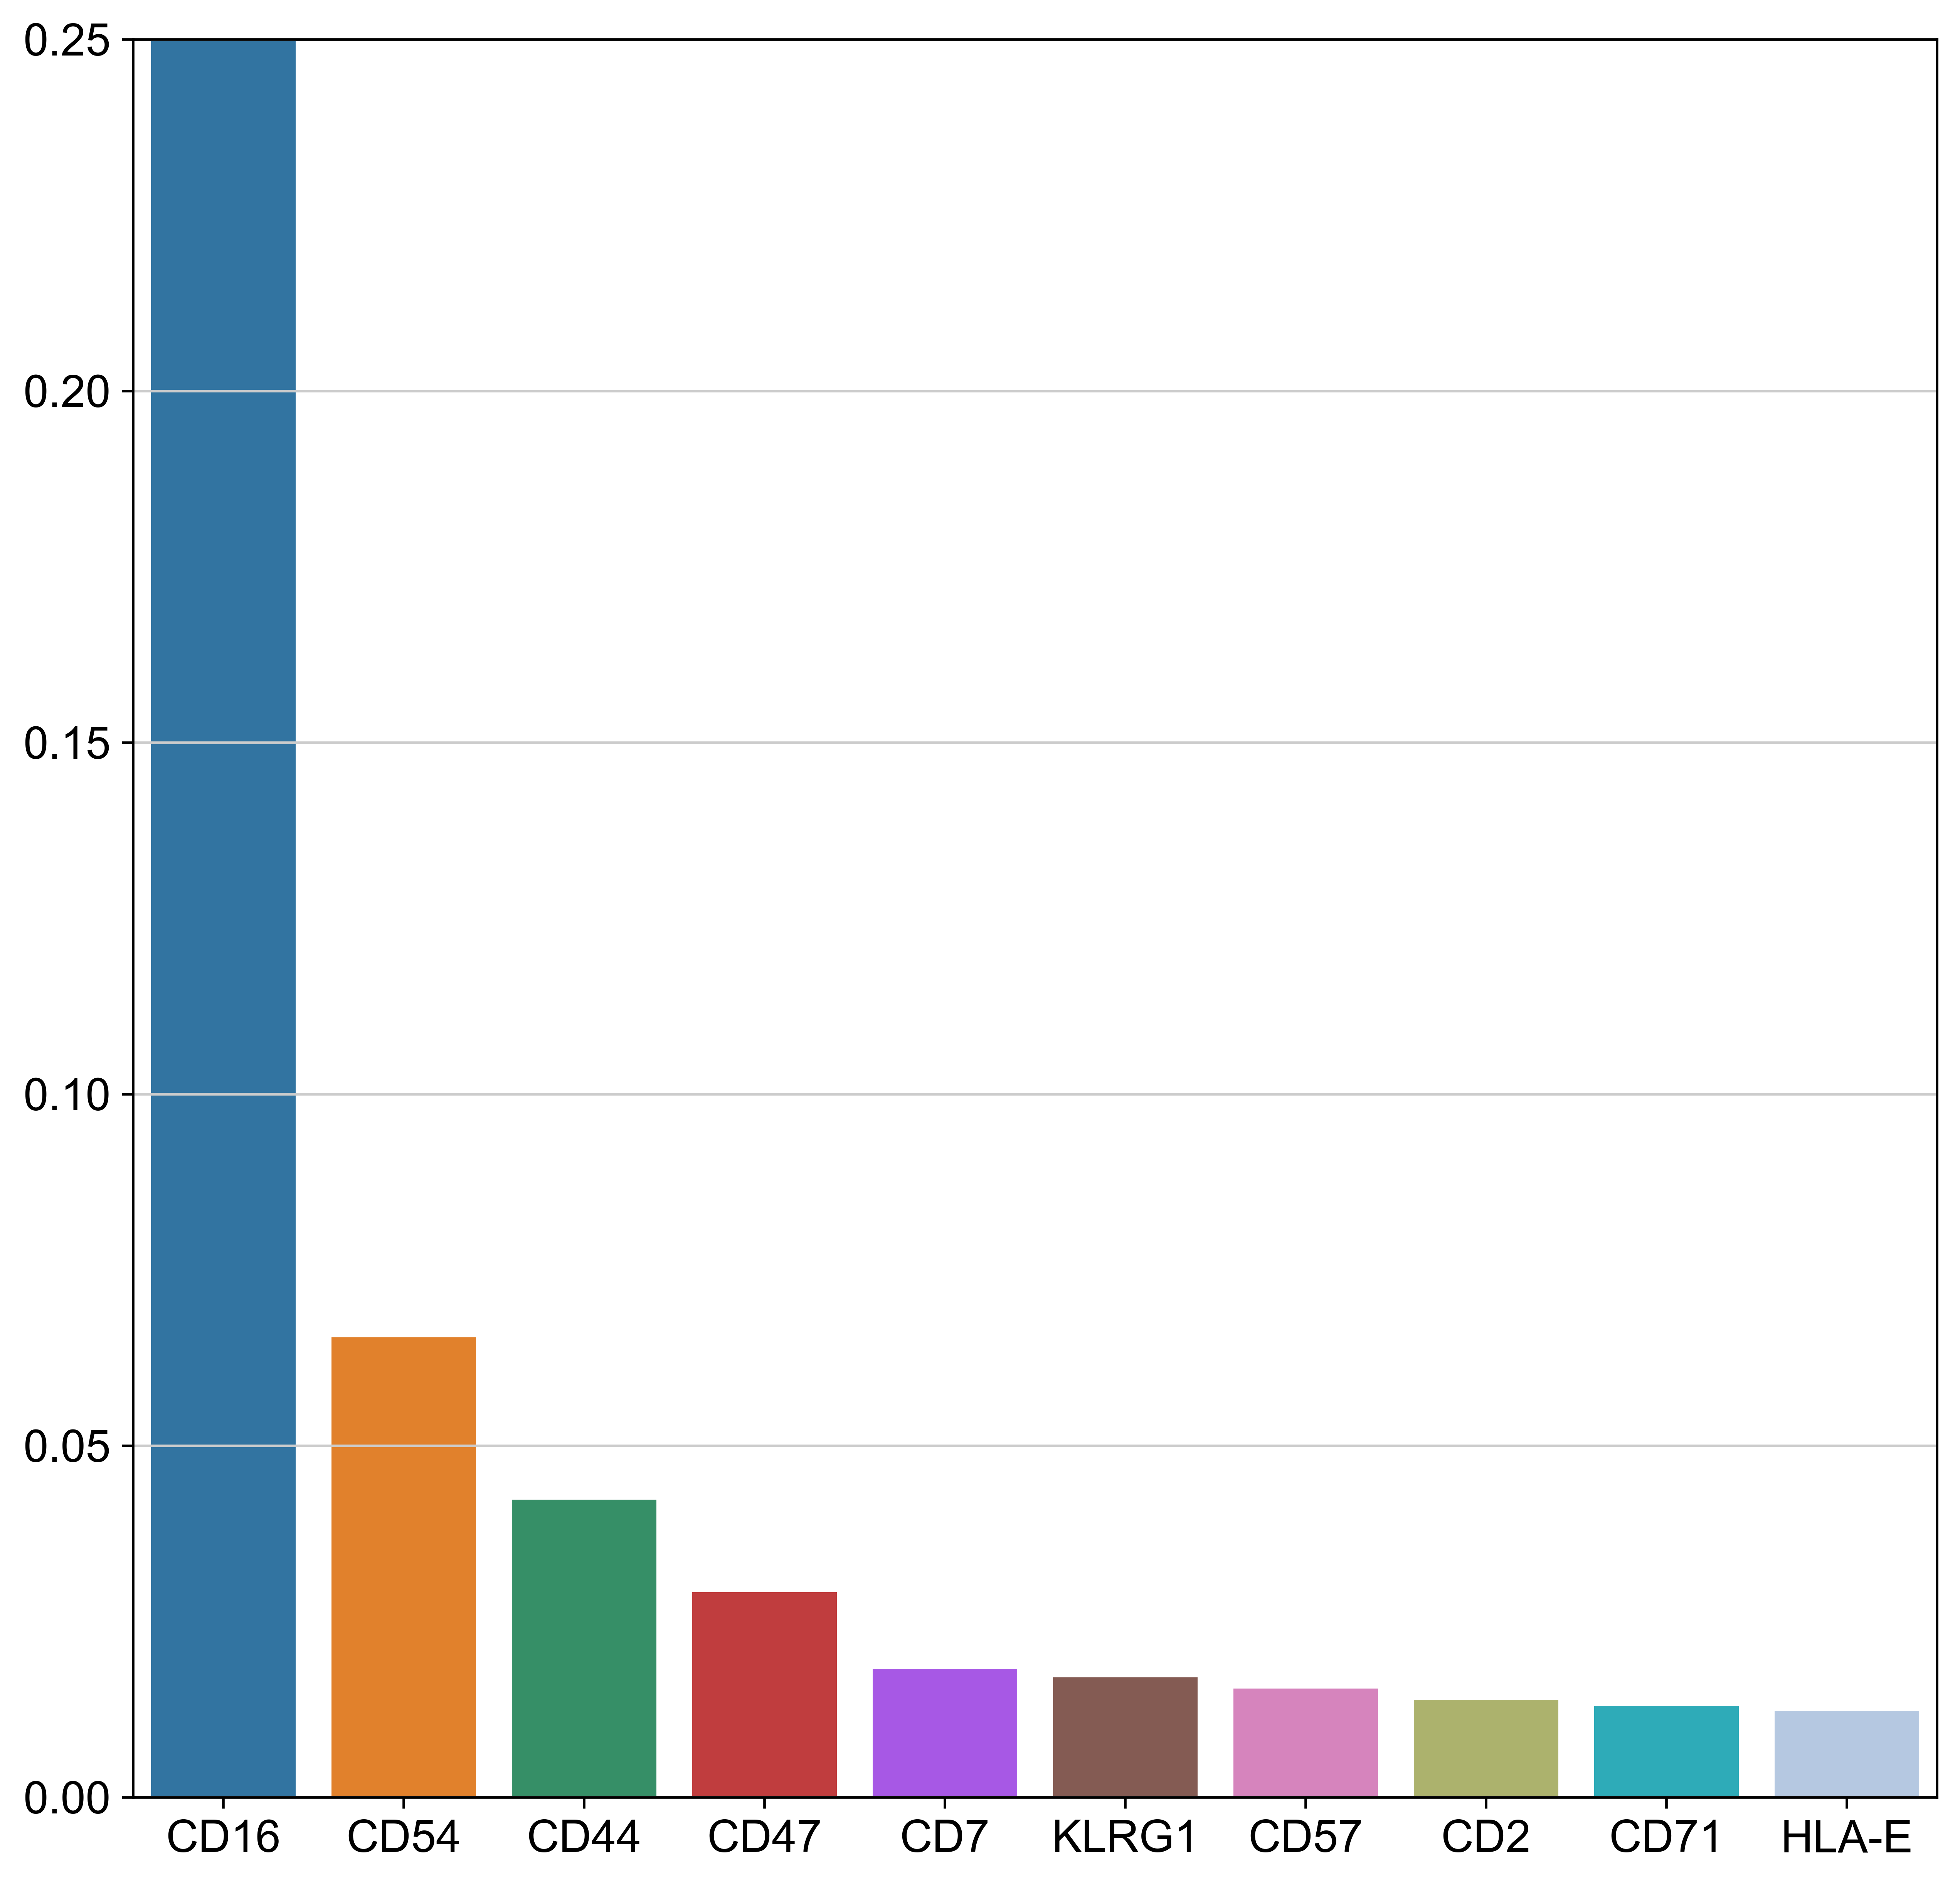

In [46]:
plt.figure(figsize=(10,10))
plt.ylim(0,0.25)
a=sb.barplot(data=importances_rf_top)

#plt.title("Top-20 important markers for gene set defining lt-NK cells (RandomForest)", fontsize = 30) ;


## 2. Dummy Reggressor

In [49]:
from sklearn.dummy import DummyRegressor

X = df.iloc[:, 1:]
y = df['mature_score_yang']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

lm_dummy_mean = DummyRegressor(strategy = 'mean').fit(X_train, y_train)
  
lm_dummy_median = DummyRegressor(strategy = 'median').fit(X_train, y_train)

y_predict_dummy_mean = lm_dummy_mean.predict(X_test)
y_predict_dummy_median = lm_dummy_median.predict(X_test)

In [50]:
print("Mean squared error (dummy): {:.2f}".format(mean_squared_error(y_test, 
                                                                     y_predict_dummy_mean)))
  
print("r2_score (dummy mean): {:.2f}".format(r2_score(y_test, y_predict_dummy_mean)))
print("r2_score (dummy median): {:.2f}".format(r2_score(y_test, y_predict_dummy_median)))

Mean squared error (dummy): 0.14
r2_score (dummy mean): -0.00
r2_score (dummy median): -0.02


## 3. GragientBoostingRegressor

In [51]:
#Gradient boosting regressor

from sklearn.ensemble import GradientBoostingRegressor

X = df.iloc[:, 1:]
y = df['mature_score_yang']

mean_train_score = []

params =  {'max_depth': [3,5,7],
          'min_samples_leaf': [2, 5, 10]}


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)


#Step 2: hyperparameter search
search= GridSearchCV(GradientBoostingRegressor(), params, cv= 10, scoring='neg_mean_squared_error', return_train_score = True)
result = search.fit(X_train,y_train)
#collecting training scores and saving into mean_train_score
train_scores_mean = (search.cv_results_['mean_train_score']) 
mean_train_score.append(train_scores_mean)
#Step 3: Performance on test set
best_model_gbr = result.best_estimator_
y_pred = best_model_gbr.predict(X_test)

MSE = mean_squared_error(y_test, y_pred)
R2= r2_score(y_test, y_pred)
    
print("Mean squared error: %.2f" % MSE, 'R2 score: %.2f'% R2)

Mean squared error: 0.09 R2 score: 0.36


In [52]:
print(mean_train_score)

[array([-0.04889667, -0.04919497, -0.05055408, -0.01390197, -0.01472349,
       -0.01787516, -0.00166574, -0.00204454, -0.00431131])]


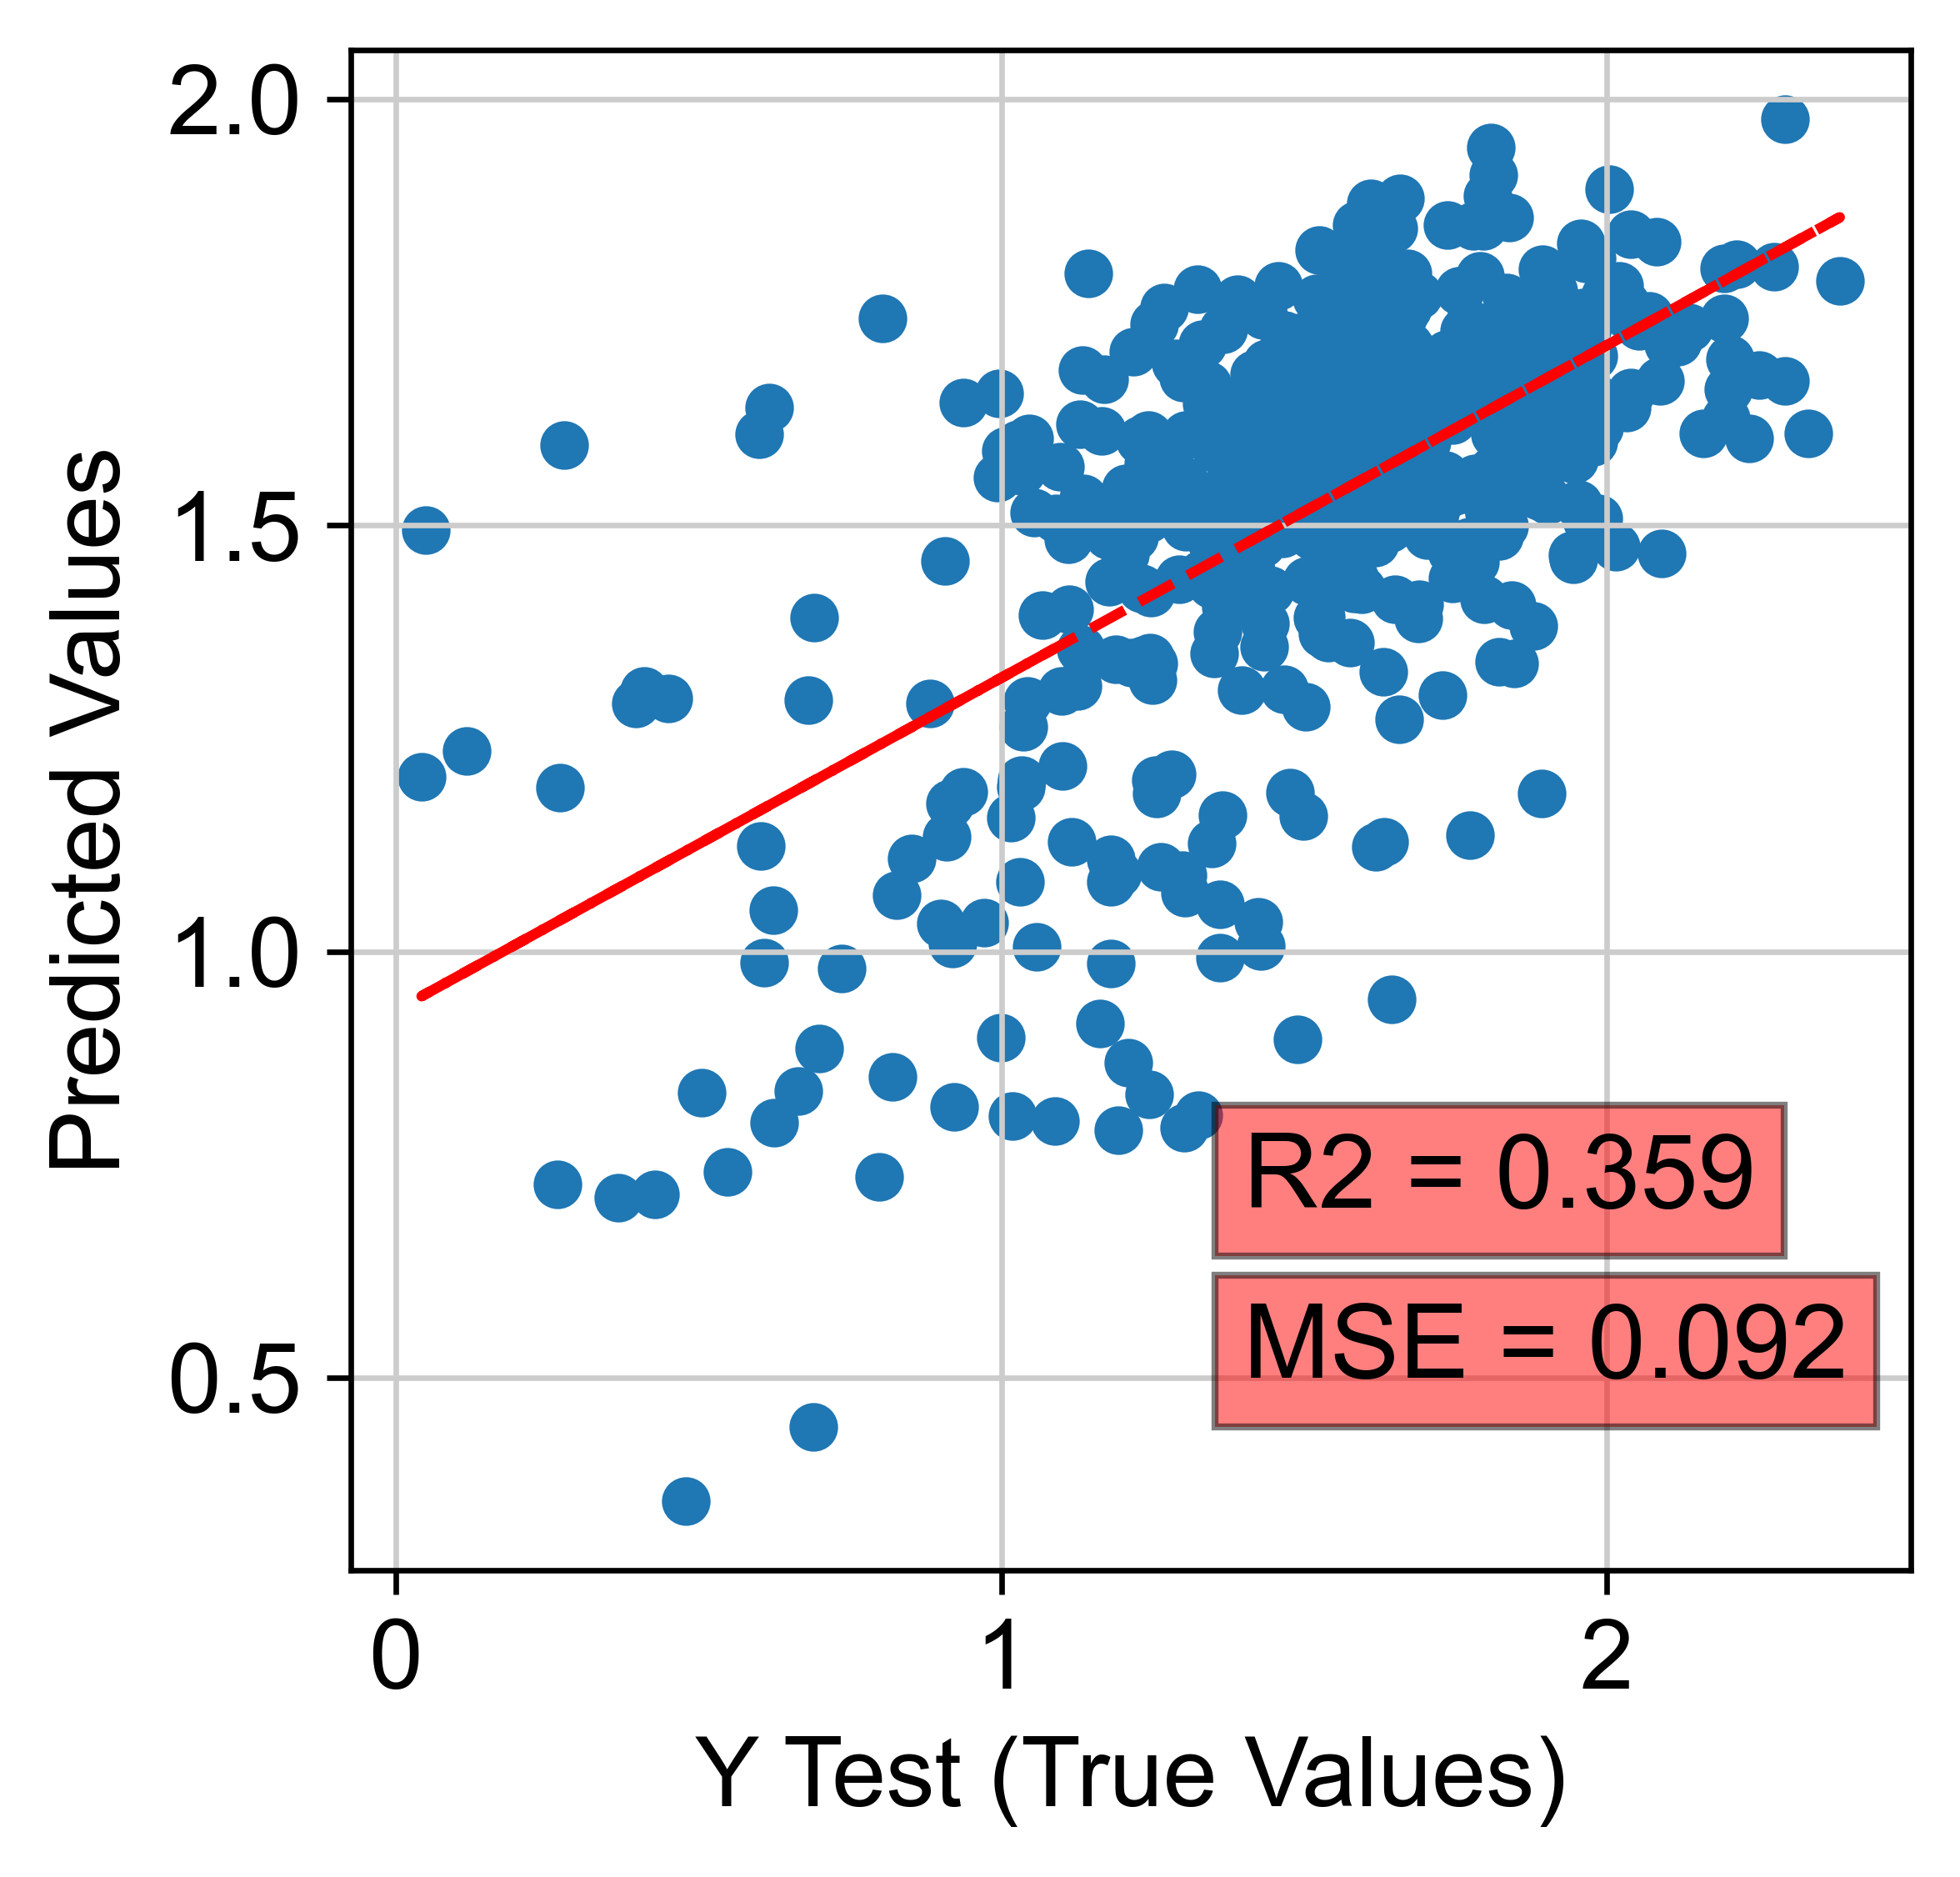

In [57]:
dict_error = { "Mean Squared Error": MSE,
             'R2': R2}


{ "Mean Squared Error": MSE,
             'R2': R2}
plt.scatter(y_test, y_pred)

# Add a trendline
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), 'r--')
# Add labels
plt.xlabel('Y Test (True Values)')
plt.ylabel('Predicted Values')

plt.annotate("MSE = {:.3f}".format(MSE), (1.4, 0.5), bbox = dict(facecolor = 'red', alpha = 0.5), fontsize=15)

plt.annotate("R2 = {:.3f}".format(R2), (1.4, 0.7), bbox = dict(facecolor = 'red', alpha = 0.5), fontsize=15)


plt.show()

<AxesSubplot: xlabel='mature_score_yang', ylabel='Density'>

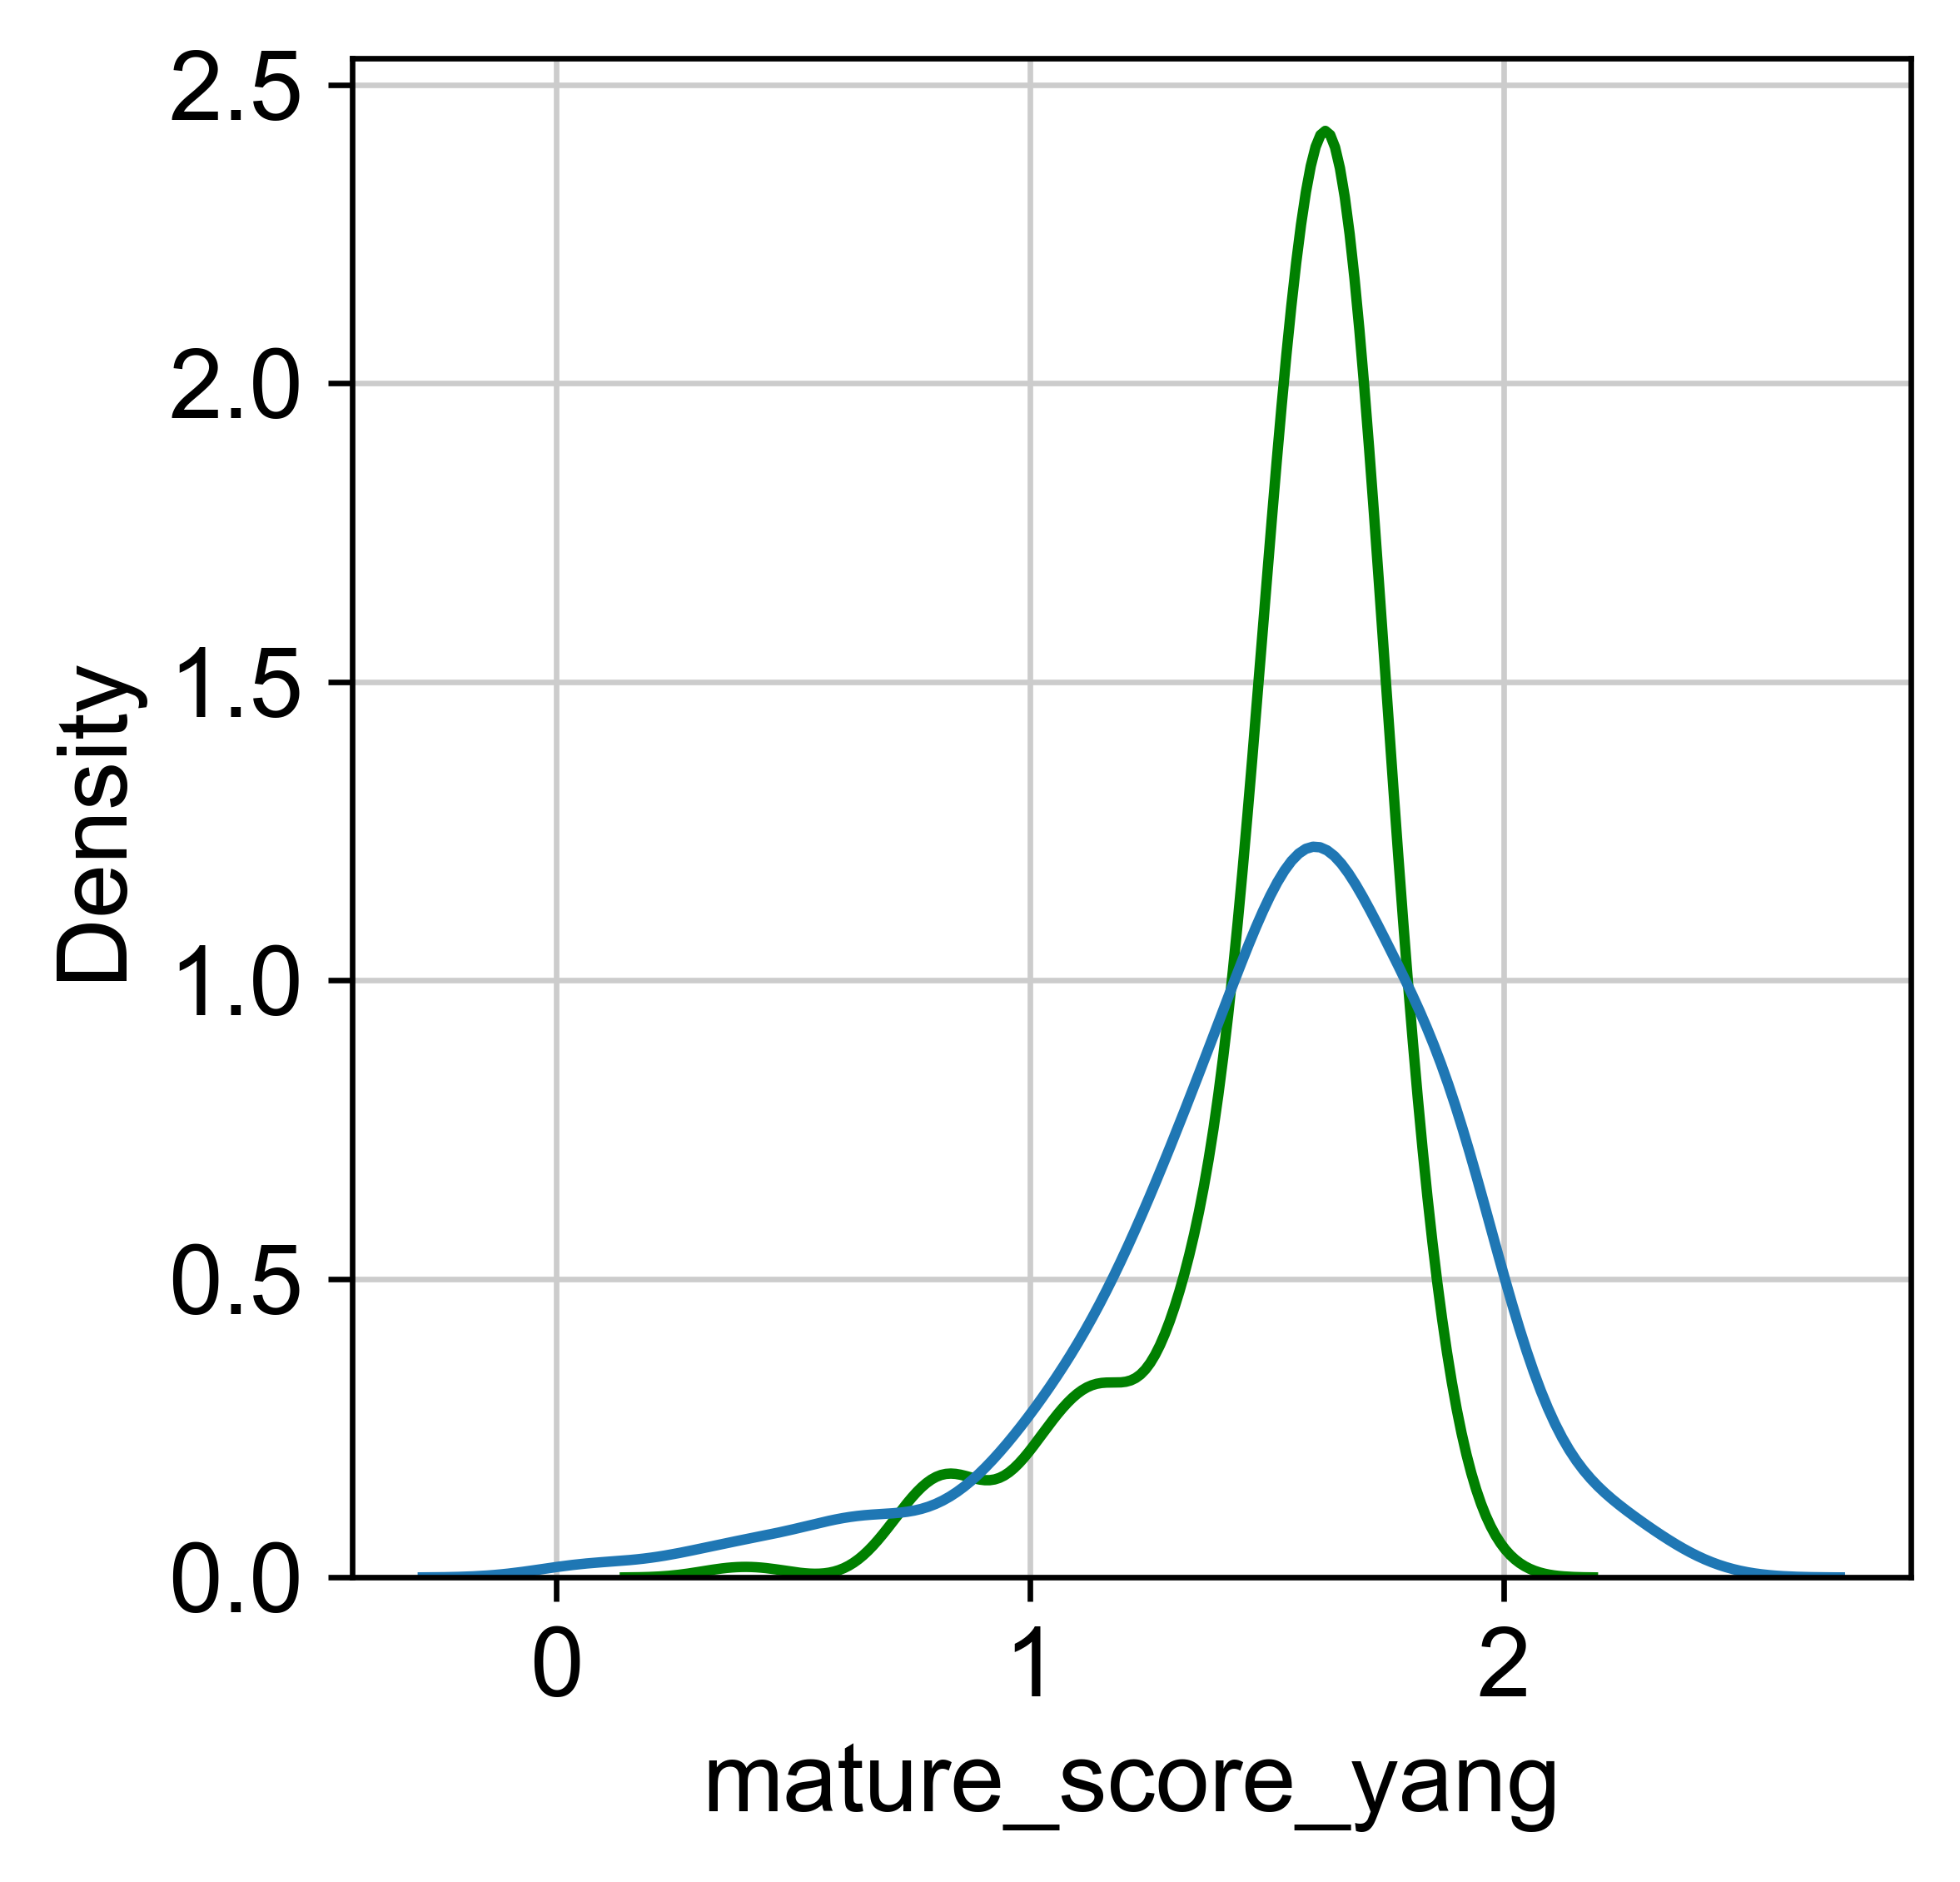

In [58]:
sb.kdeplot(y_pred, color = "g")
sb.kdeplot(y_test)

In [59]:
importances_gbr = best_model_gbr.feature_importances_
importances_gbr = pd.Series(importances_gbr, index=prot.columns)
importances_gbr=importances_gbr.sort_values(ascending=False)

print(importances_gbr.head(10))

CD16     0.255087
CD44     0.046205
CD54     0.041599
CD47     0.038455
CD7      0.020619
HLA-E    0.017610
CD162    0.016845
CD57     0.016342
CD328    0.015374
CD335    0.014946
dtype: float64


In [60]:
#df from the top 20 important markers
importances_gbr=pd.DataFrame(importances_gbr)
importances_gbr_top=importances_gbr[0:10]
importances_gbr_top=importances_gbr_top.T

/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


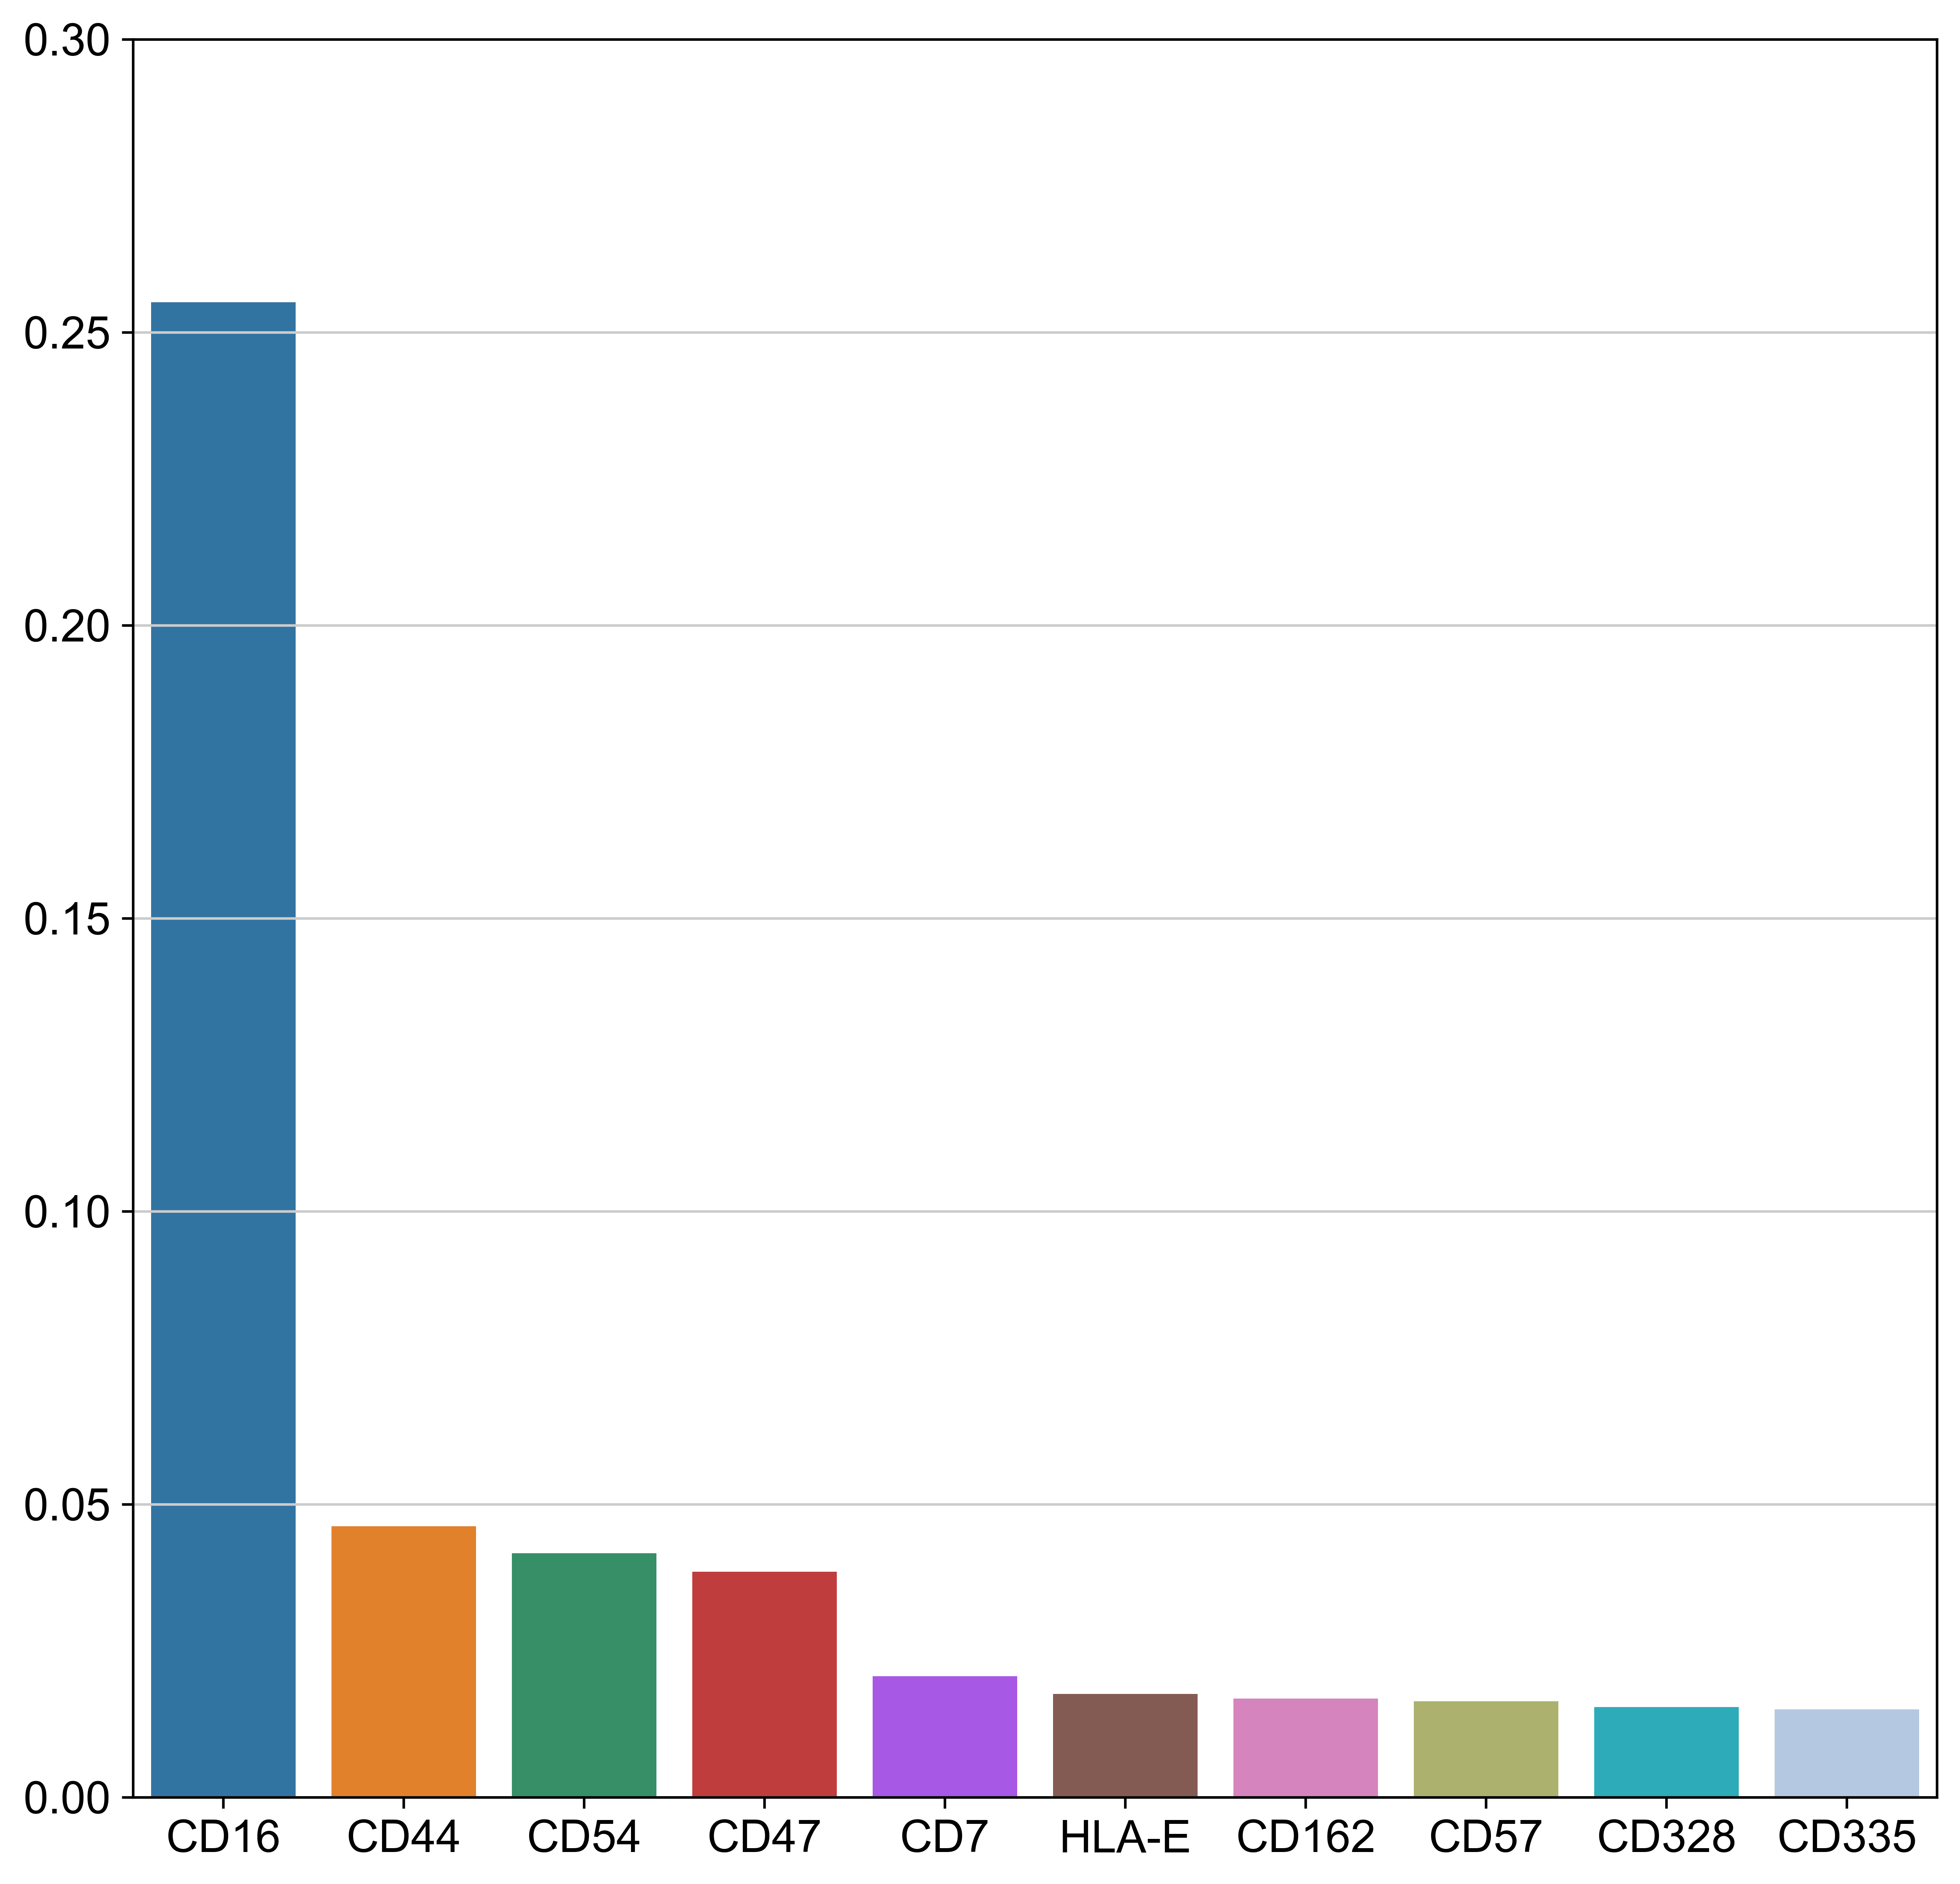

In [63]:
plt.figure(figsize=(10,10))
plt.ylim(0,0.30)
a=sb.barplot(data=importances_gbr_top)

#plt.title("Top-20 important markers for gene set defining lt-NK cells (GradientBoostingReggressor)", fontsize = 30) ;



## 4. CatBoostRegressor

In [64]:
from catboost import CatBoostRegressor

X = df.iloc[:, 1:]
y = df['mature_score_yang']

mean_train_score = []

params= {'depth': [6,8,10],
        'learning_rate' : [0.01, 0.05, 0.1],
        'iterations'    : [30, 50, 100]
                 }

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)


#Step 2: hyperparameter search
search= GridSearchCV(CatBoostRegressor(), params, cv= 10, scoring='neg_mean_squared_error', return_train_score = True)
result = search.fit(X_train,y_train, verbose = 0)
#collecting training scores and saving into mean_train_score
train_scores_mean = (search.cv_results_['mean_train_score']) 
mean_train_score.append(train_scores_mean)
#Step 3: Performance on test set
best_model_cb = result.best_estimator_
y_pred = best_model_cb.predict(X_test)

MSE = mean_squared_error(y_test, y_pred)
R2= r2_score(y_test, y_pred)
    
print("Mean squared error: %.2f" % MSE, 'R2 score: %.2f'% R2)

Mean squared error: 0.09 R2 score: 0.39


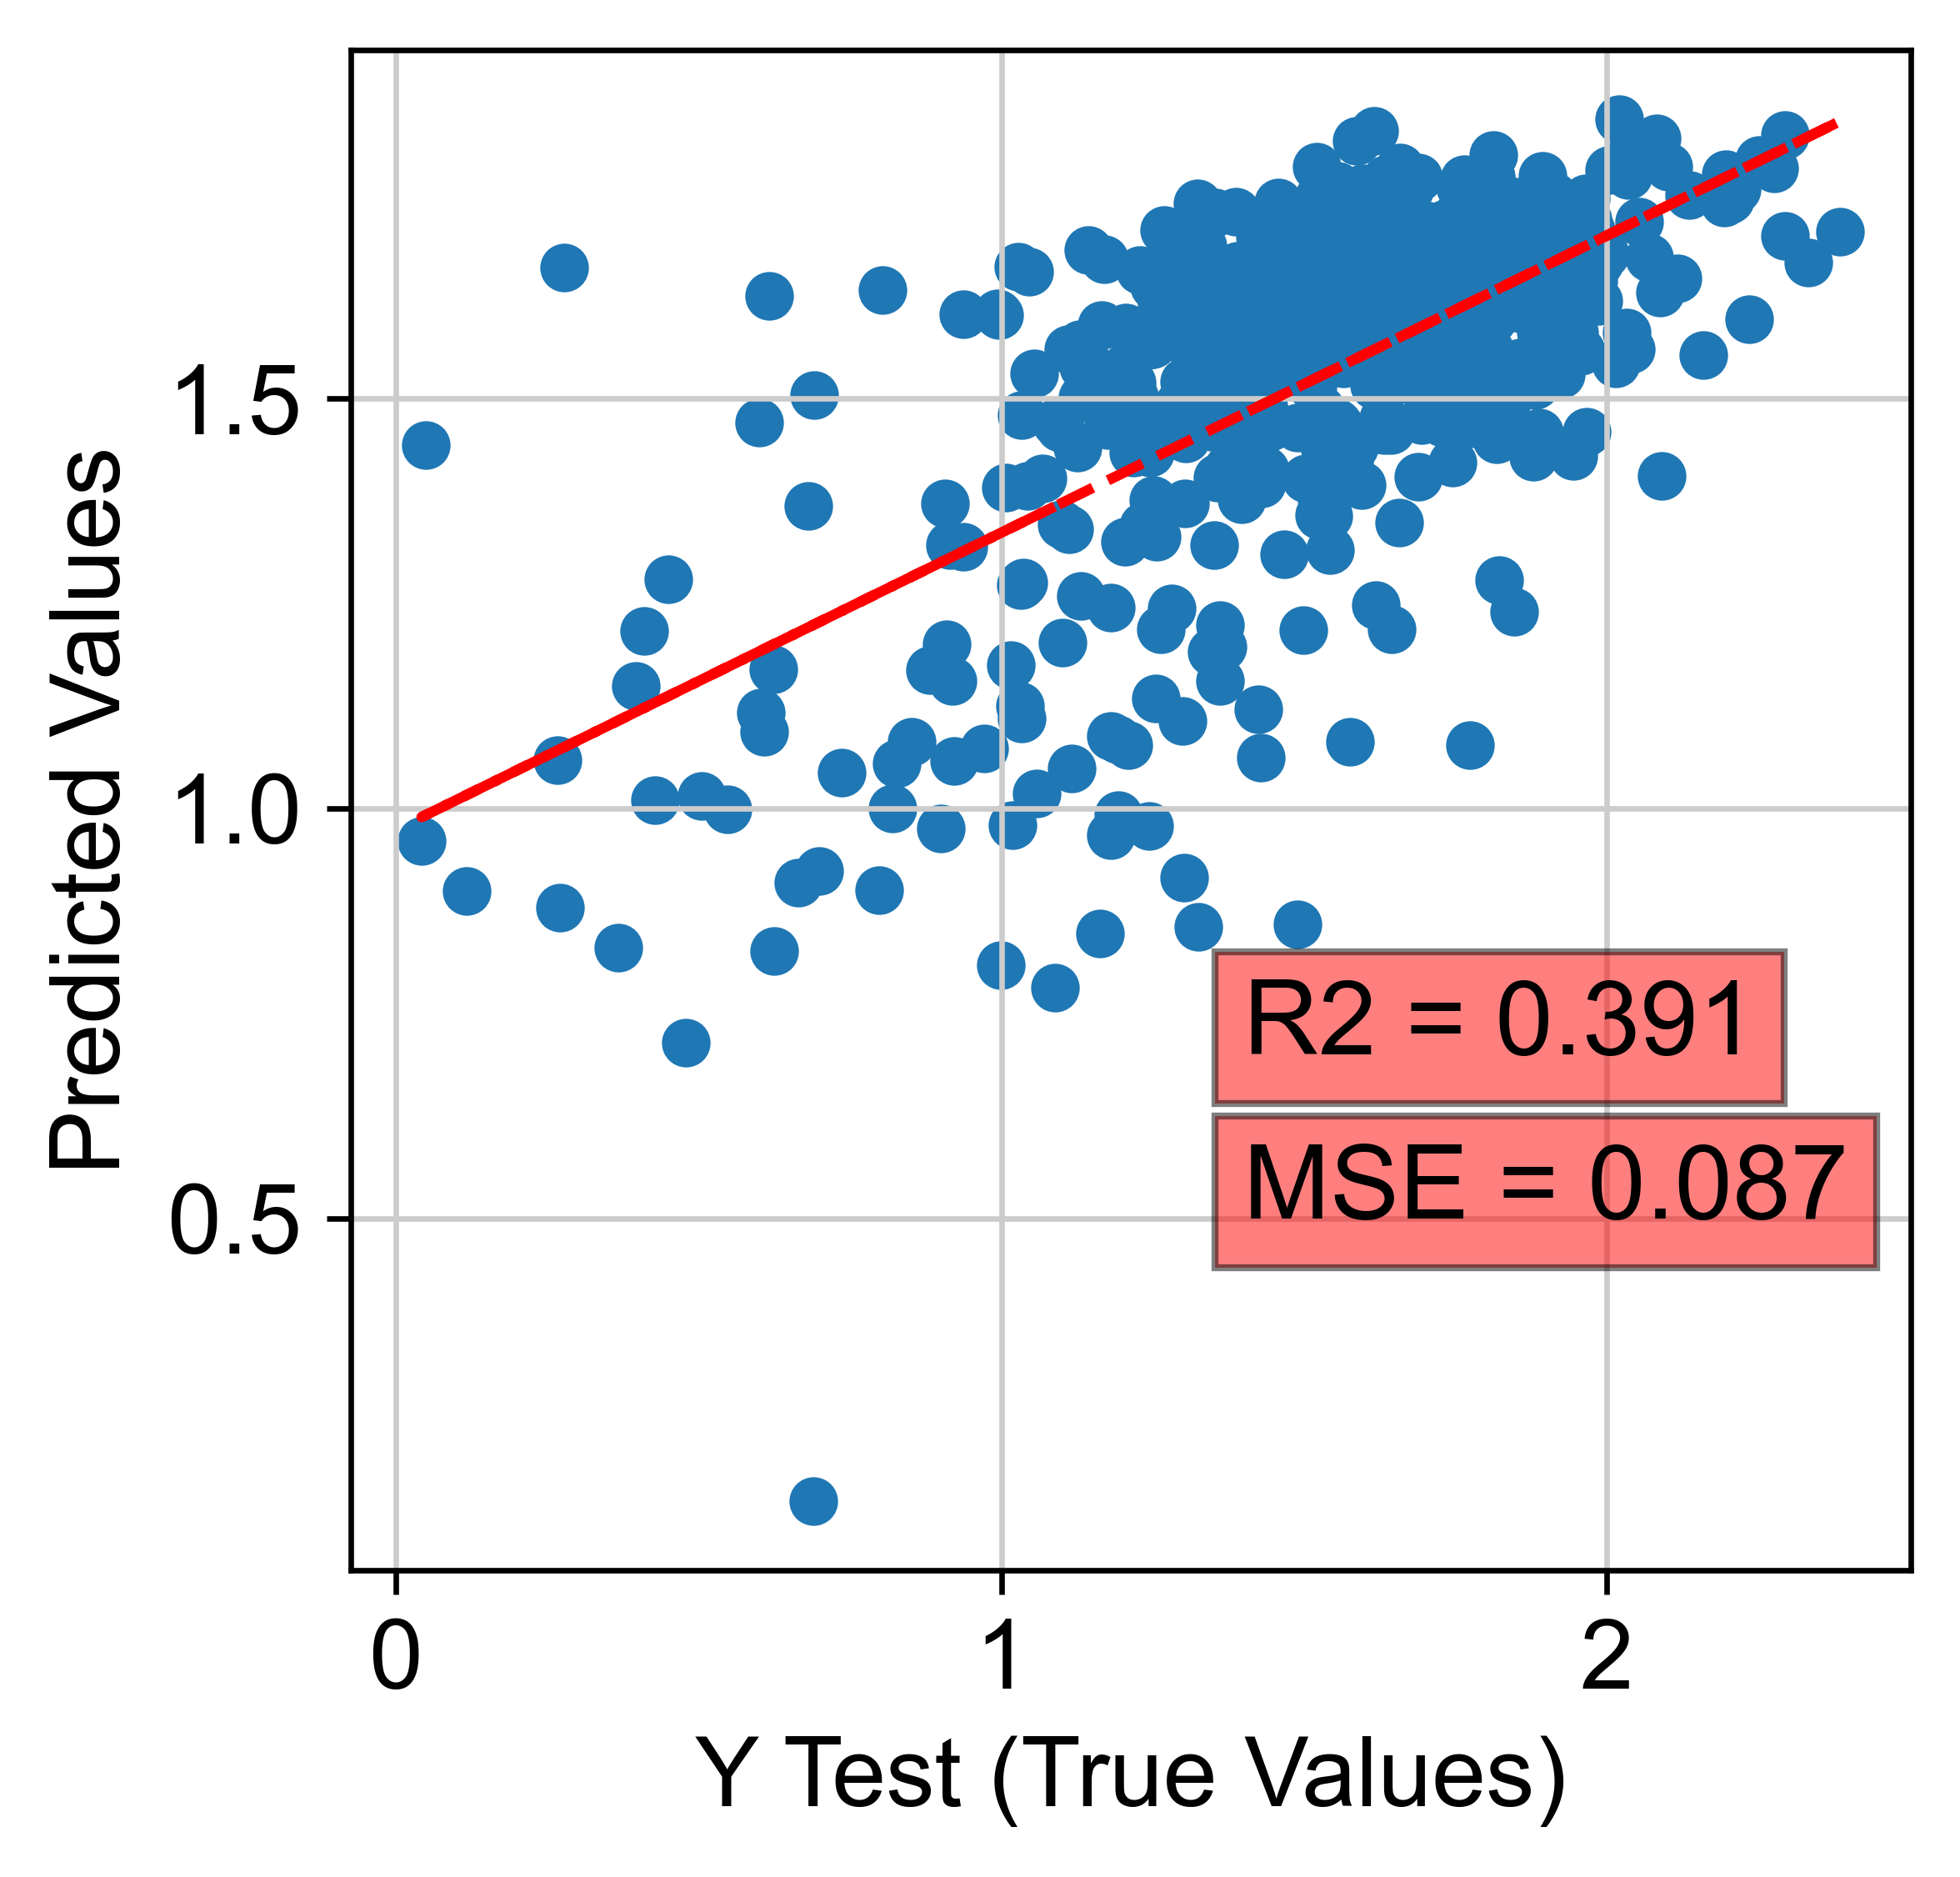

In [67]:
dict_error = { "Mean Squared Error": MSE,
             'R2': R2}


{ "Mean Squared Error": MSE,
             'R2': R2}
plt.scatter(y_test, y_pred)

# Add a trendline
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), 'r--')
# Add labels
plt.xlabel('Y Test (True Values)')
plt.ylabel('Predicted Values')

plt.annotate("MSE = {:.3f}".format(MSE), (1.4, 0.5), bbox = dict(facecolor = 'red', alpha = 0.5), fontsize=15)

plt.annotate("R2 = {:.3f}".format(R2), (1.4, 0.7), bbox = dict(facecolor = 'red', alpha = 0.5), fontsize=15)


plt.show()

<AxesSubplot: xlabel='mature_score_yang', ylabel='Density'>

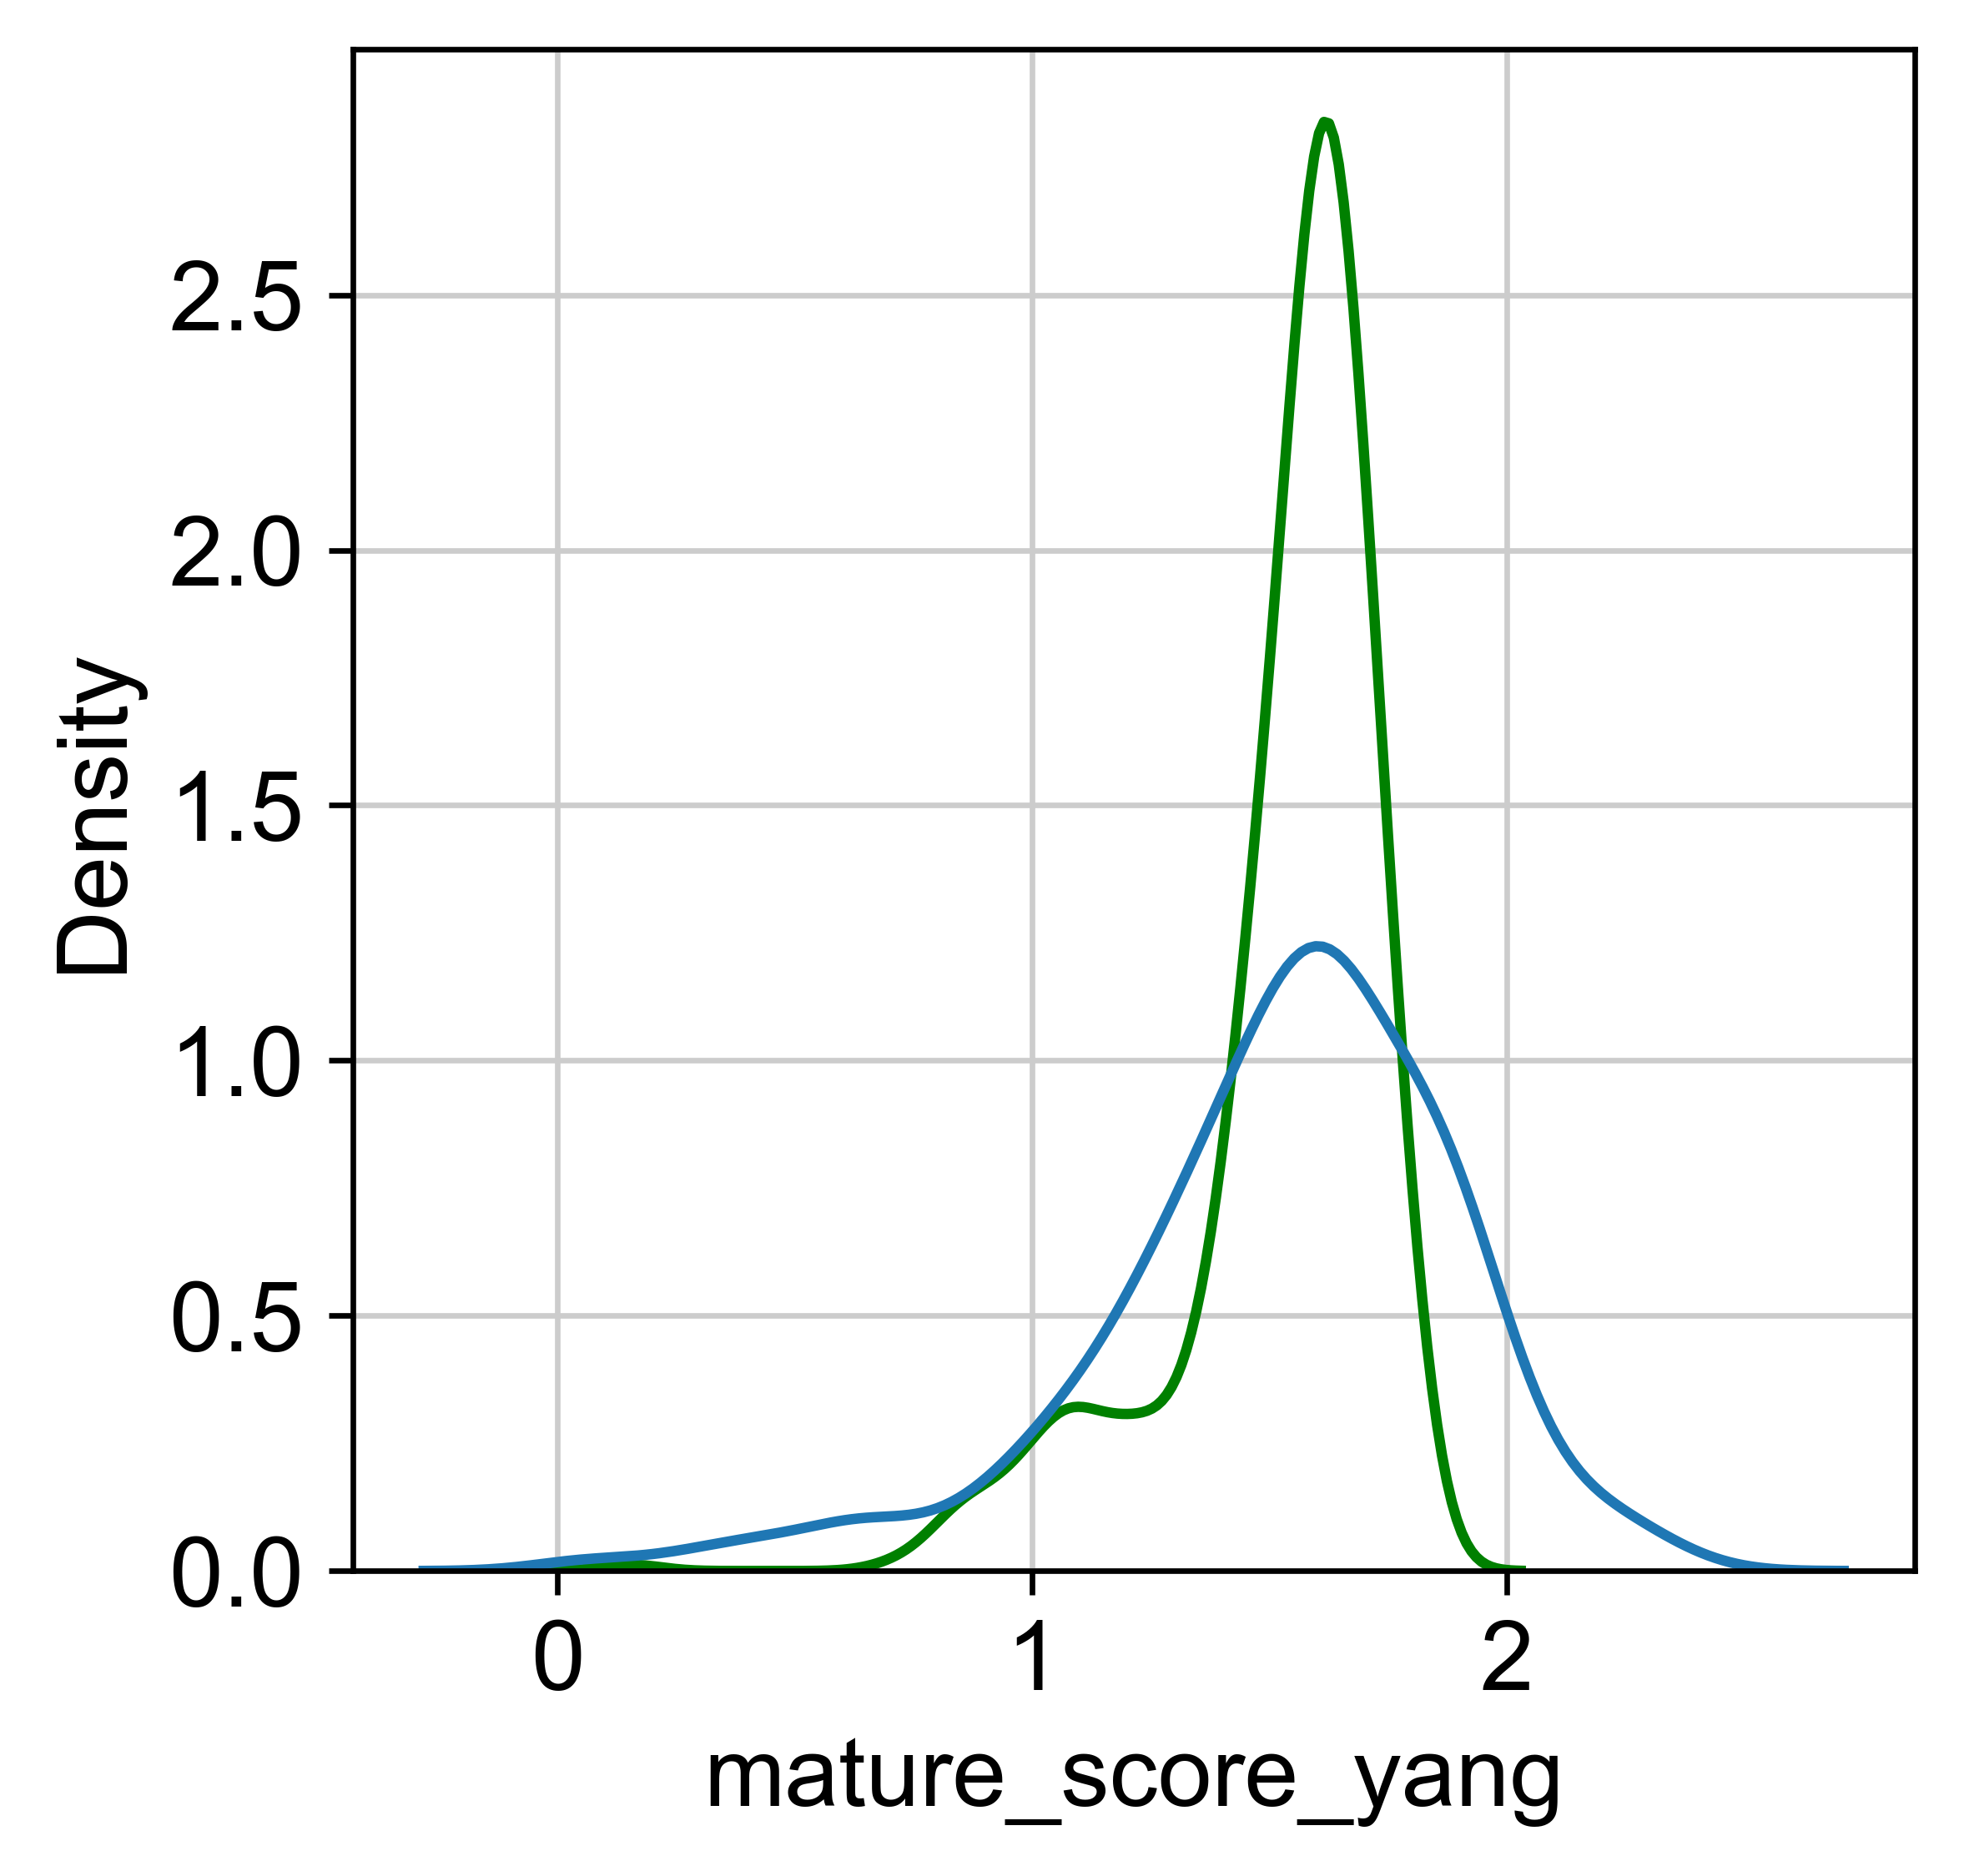

In [68]:
sb.kdeplot(y_pred, color = "g")
sb.kdeplot(y_test)

In [69]:
importances_cb = best_model_cb.feature_importances_
importances_cb = pd.Series(importances_cb, index=prot.columns)
importances_cb=importances_cb.sort_values(ascending=False)

print(importances_cb.head(10))

CD16     19.058764
CD44      6.334037
CD47      6.096450
CD54      4.183628
CD7       3.447818
HLA-E     3.134069
CD328     2.426954
CD57      2.401187
CD82      1.945501
CD314     1.865513
dtype: float64


In [70]:
#df from the top 20 important markers
importances_cb=pd.DataFrame(importances_cb)
importances_cb_top=importances_cb[0:10]
importances_cb_top=importances_cb_top.T

/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


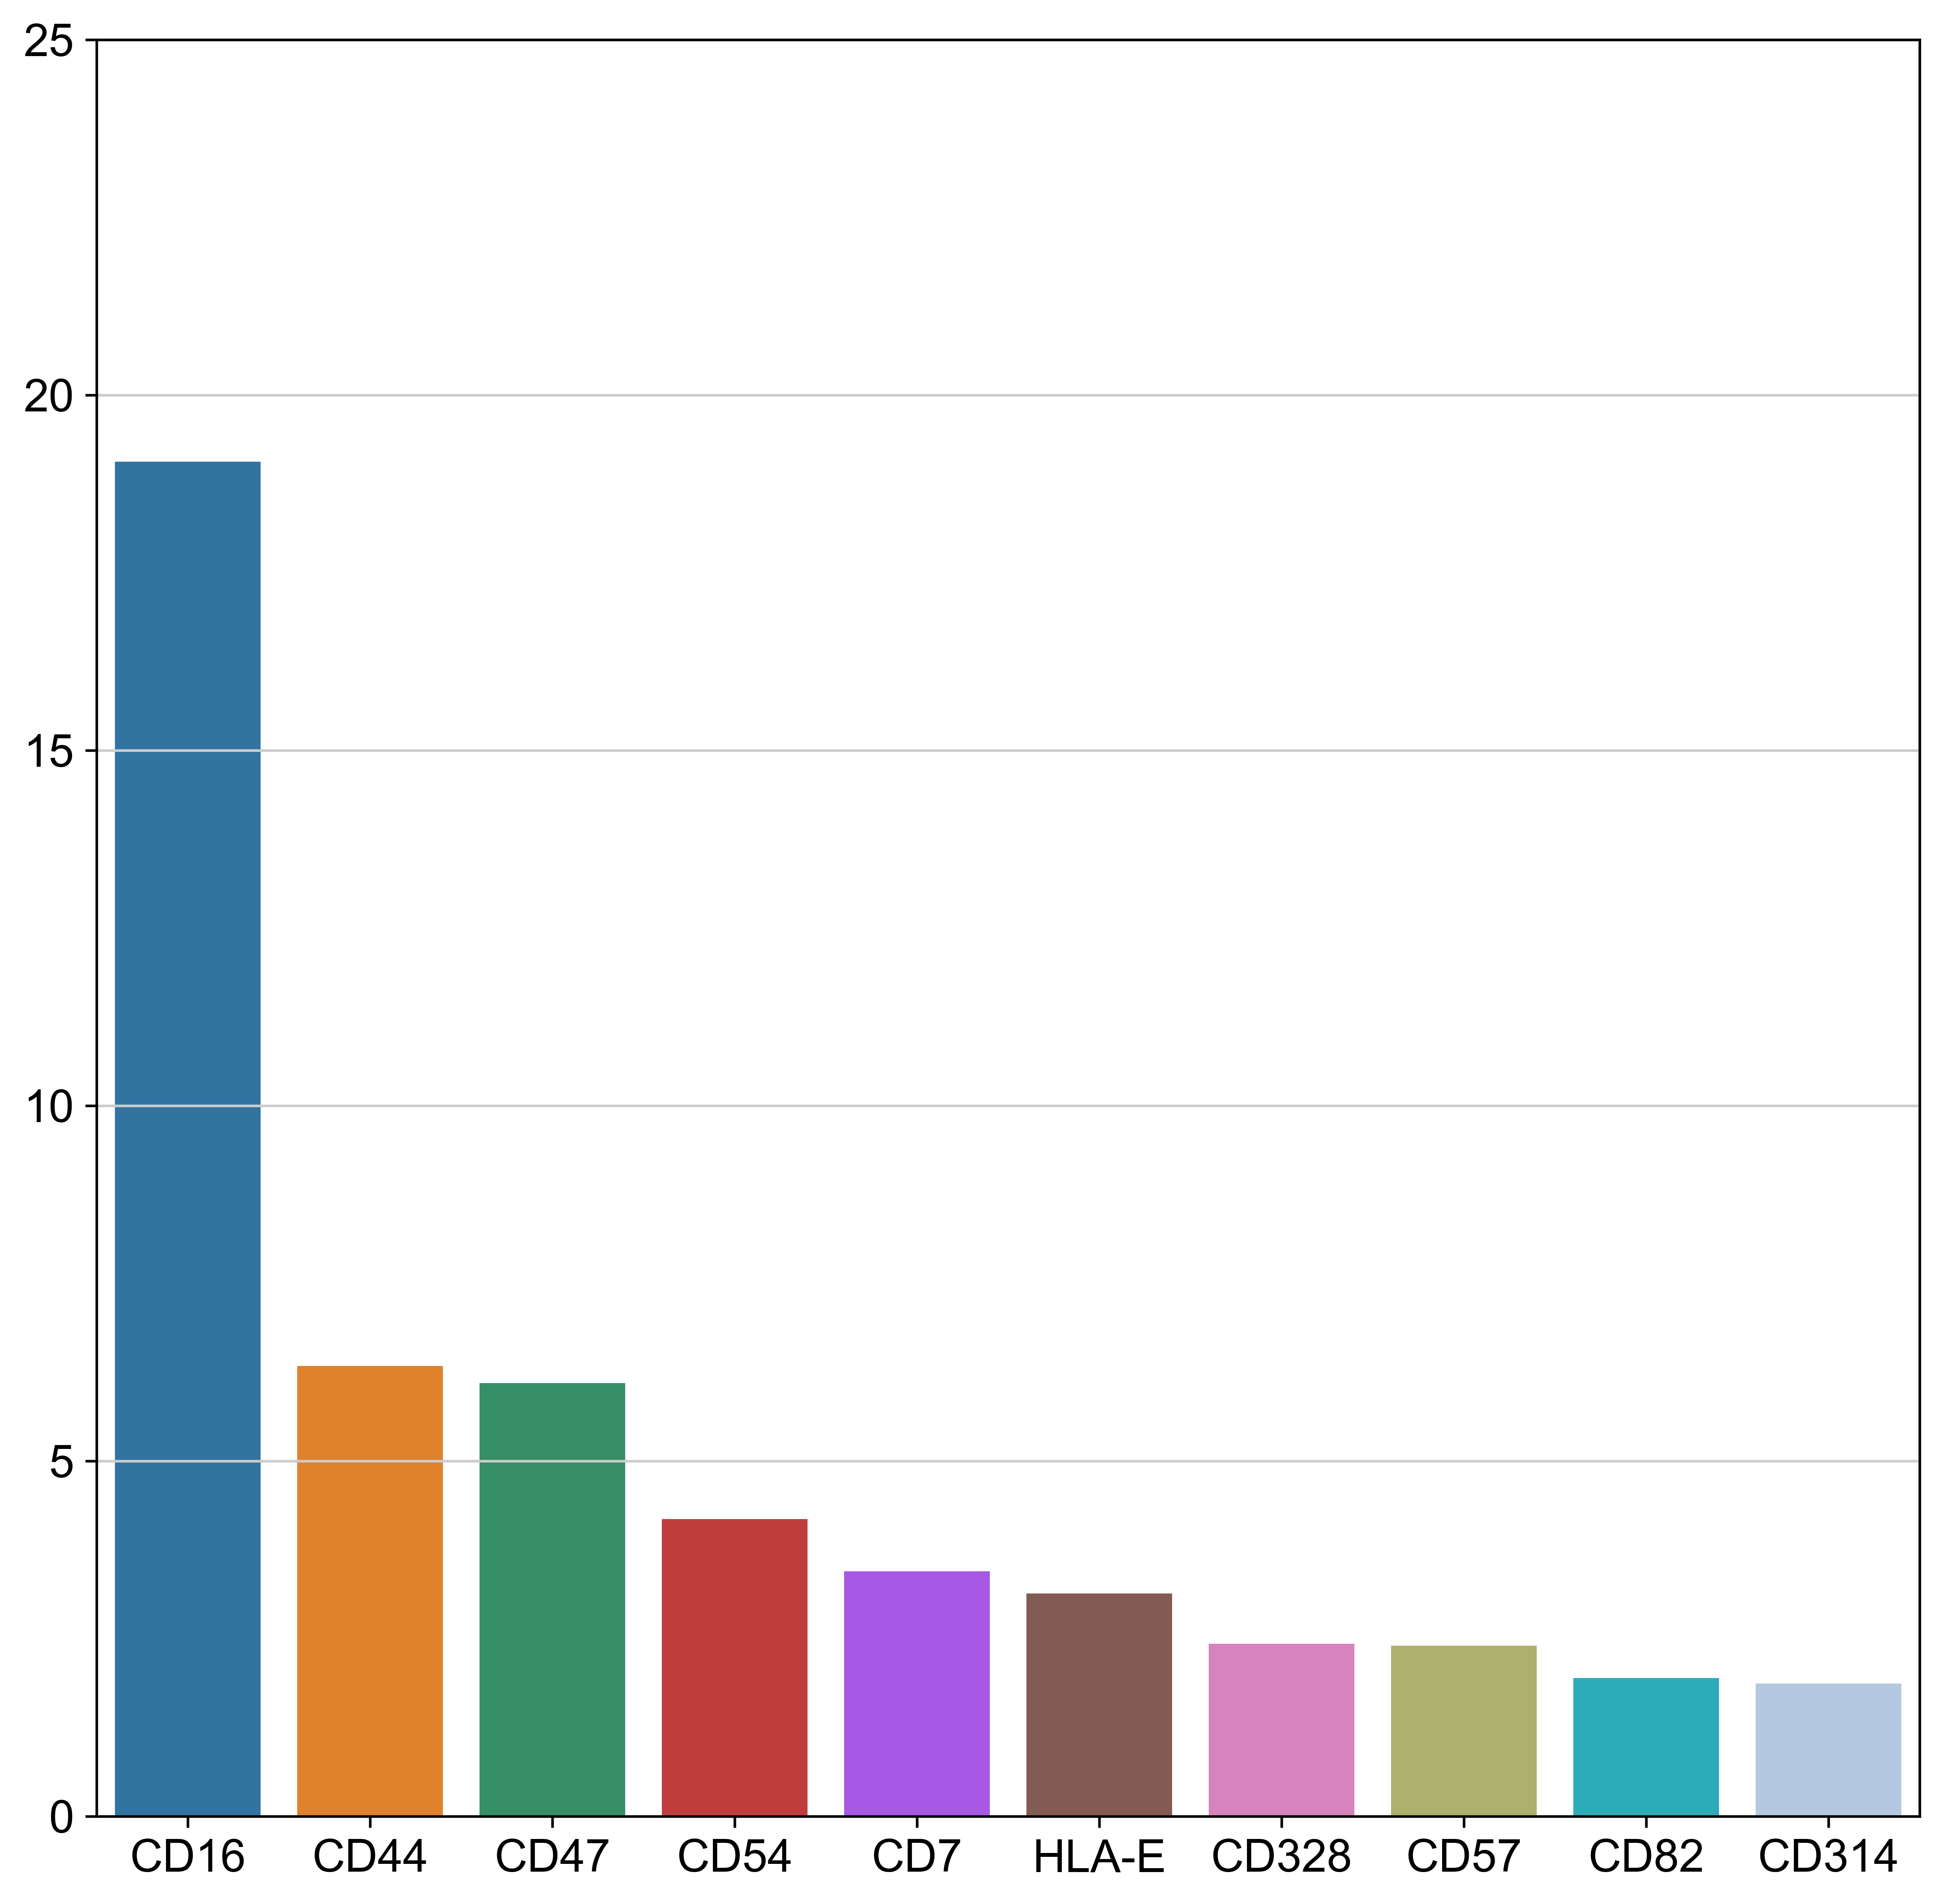

In [72]:
plt.figure(figsize=(10,10))
plt.ylim(0,25)
a=sb.barplot(data=importances_cb_top)

#plt.title("Top-20 important markers for gene set defining lt-NK cells (Catboost)", fontsize = 30) ;




Markers above are important features (surface proteins) for tissue resident NK cells identified by CatBoostReggressor. 